# 文件分類

本次練習為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：財經、社會、全球
    + 時間範圍：2024/01/01 ~ 2024/01/13
        + 聯合新聞網的版別：產經、股市、社會、國際、要聞
        + 聯合新聞網的產經版與股市版合併為財經版
            + 產經(produce)、股市(stock) -> 財經(economy)
        + 東森新聞網的版別：政治、社會、國際、財經
        + 東森新聞網的政治板對應到聯合新聞網的要聞板
            + 政治(politics) -> 要聞(news)

* 分析主題：將聯合新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具  

In [61]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from matplotlib import font_manager

設定中文字體 

In [62]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


Text(0.5, 1.0, '聲量圖')

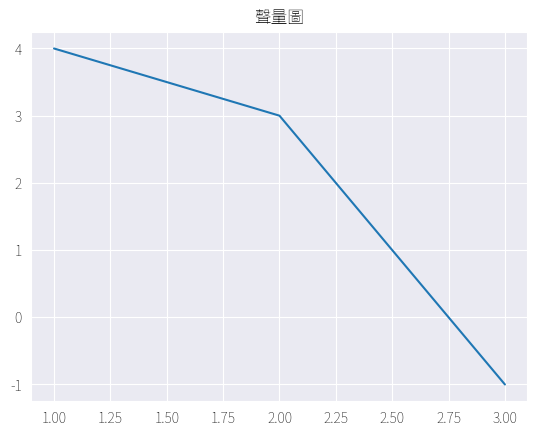

In [63]:
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

# 2. 文字前處理
`聯合新聞.csv`裡面包含了要分析的 udn 新聞資料。
- 版別：全球(global)、社會(social)、產經(produce)、股市(stock)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無
 

In [110]:
# 文字前處理
udn = pd.read_csv("data/聯合日報最新.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅家樹率將領與軍校學生代表出席，以實際行動表達對國家熱愛。蔡英文總統與賴清德副總統上午出席元旦升旗典禮，首先接受國防部三軍儀隊大隊長致敬，在歷屆十大傑出青年代表的領唱下，與現場民眾齊唱國歌，在國旗歌演奏聲中，國旗緩緩升起。國防部表示，民國113年元旦總統府升旗典禮，以活力台灣，世代永續為主題，由蔡總統親自主持，全場軍民在歷屆十大傑出青年代表領唱下，齊唱國歌，以實際行動表達對國家的熱愛與認同。國防部說，邱國正清晨率領梅家樹、國防部副部長柏鴻輝、國防部副部長徐衍璞與各聯參單位代表，以及陸、海、空軍官校，國防大學政治作戰學院、管理學院、理工學院，國防醫學院、陸軍專科學校、空軍航技學院及中正預校等10所軍事校院學生代表，共同參加元旦總統府升旗典禮，以實際行動表達對國家的熱愛。國防部表示，今年國防部示範樂隊及三軍儀隊配合大會企畫主軸活力台灣，世代永續，以從戎回憶進行曲、黃埔軍魂、領航者、英勇勳章等4首曲目，搭配儀隊官兵走位變化及花式操槍，展現壯盛軍容，更象徵國軍是民主台灣的領航者，面對困難與挑戰，仍勇往直前。 ▪ 政黨票能幹嘛？4神秘數字搶席次、領補助、還可扣稅 ▪ 大選結果繫在年輕人手上？2016、2020投票率直接「差1格」 ▪ 政見會後情勢生變？最新5家媒體民調一次看 ▪ 立委抽籤結果出爐！選區名單、號次一次看 ▪ 影／3組拚總統 選民抱不平：幹嘛蹚這趟渾水？ 國防部元旦升旗蔡英文 總統蔡英文曾親自體驗掛保證「很好操作」的國造紅隼火箭彈，陸軍採購五千枚今年趕工生產，陸軍同時採購六十套射擊模擬器，準備提... 中科院系製中心日前展示國造紅隼火箭彈模擬器，表示這種小巧的單兵肩射型武器系統，具備城鎮作戰便於攜帶的優越性，有利於單兵各... 中科院以六六火箭彈為藍本研發紅隼火箭彈，是蔡政府國防自主象徵之一，性能受肯定，但以實需而言，這項裝備顯然成為宣傳義務役延... 國防部今天表示，國軍廉能施政已獲國際肯定。而國軍一貫秉持「備戰不求戰、應戰不避戰」態度，持恆強化各項戰力整建與戰備整備。 針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱「你不能靠義務軍人，靠義務去打仗，當然是職業軍人為主」，賴清德競總... 因應兵役延長一年，國防部今天表示，已配合全國檢察長座談時機，請檢察官嚴肅看待暴行、抗命及聚眾鬥毆等破壞軍紀案件。,UDN
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過談判，爭取由漢翔建立廠級維修中心。漢翔公司說，F-16維修中心預計2024年第一季完成驗證，支援空軍機隊妥善。據了解，我國對美採購66架F-16C/D BLOCK70戰機，將動用工業合作點數，與美談判在台直接廠級維修。漢翔成立的F-16維修中心，目前已取得原廠洛馬數百項維修認證，目前積極爭取在台產置若干系統件，希望納入美全球F-16供應鏈。針對66架F-16在台實施廠級維修案的談判進度，軍備局表示，台美工業合作均依軍種建案需求執行，由經濟部協助移轉關鍵技術，擴大國內軍民工廠維修能量。軍備局續依各軍種建案需求，持續爭取，以維裝備戰力維持。漢翔公司說，台美工業合作均依軍種建案需求執行，由經濟部協助移轉關鍵技術，擴大國內軍民工廠維修能量。漢翔位於台中水湳的F-16維修中心2020年8月28日成立，目前已獲原廠授權展開維修工作，各項能量正逐步建構完善，預計今年第一季完成驗證，持續結合國內廠商，支援空軍機隊妥善。 ▪ 政黨票能幹嘛？4神秘數字搶席次、領補助、還可扣稅 ▪ 大選結果繫在年輕人手上？2016、2020投票率直接「差1格」 ▪ 政見會後情勢生變？最新5家媒體民調一次看 ▪ 立委抽籤結果出爐！選區名單、號次一次看 ▪ 影／3組拚總統 選民抱不平：幹嘛蹚這趟渾水？ F-16空軍戰機 總統蔡英文曾親自體驗掛保證「很好操作」的國造紅隼火箭彈，陸軍採購五千枚今年趕工生產，陸軍同時採購六十套射擊模擬器，準備提... 中科院系製中心日前展示國造紅隼火箭彈模擬器，表示這種小巧的單兵肩射型武器系統，具備城鎮作戰便於攜帶的優越性，有利於單兵各... 中科院以六六火箭彈為藍本研發紅隼火箭彈，是蔡政府國防自主象徵之一，性能受肯定，但以實需而言，這項裝備顯然成為宣傳義務役延... 國防部今天表示，國軍廉能施政已獲國際肯定。而國軍一貫秉持「備戰不求戰、應戰不避戰」態度，持恆強化各項戰力整建與戰備整備。 針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱「你不能靠義務軍人，靠義務去打仗，當然是職業軍人為主」，賴清德競總... 因應兵役延長一年，國防部今天表示，已配合全國檢察長座談時機，請檢察官嚴肅看待暴行、抗命及聚眾鬥毆等破壞軍紀案件。,UDN
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國防部說明震撼教育訓練場設施，國軍新兵訓練震撼教育訓練目的，是讓完成八周入伍訓練的新兵，由期末鑑測結合震撼教育，驗測新兵戰鬥技能及狀況處置，同步體驗戰場景況。營區訓場設計以200公尺至250公尺為基準，場內設置土堤、門窗、家屋、外壕、屋頂型鐵絲網及高絆網等9處障礙物，機槍堡配置兩挺機槍，不間斷射擊空包彈，另以TNT炸藥每波實施兩次爆炸，模擬戰場景況。國防部表示，震撼教育測驗以一個班為單位，由鑑測官發布狀況，誘導班長帶領新兵實施班攻擊綜合教練演練，置重點於狀況處置及戰傷救護。全程由安管中心編組醫護及警戒組，負責各項安全管制措施。以往陸軍受限於場地，只有成功嶺大專寒暑訓、陸官入伍生團、陸戰隊隘寮靶場，設有震撼教育場及課程，前年起國防部通令各軍團增設場地，陸軍八軍團在官田增設一座震撼教育場。據了解，義務役役男的震撼教育場與三軍入伍生團場地有些許差異，三軍入伍生團的TNT會在通道兩側同時爆破，新訓為單側爆破，三軍入伍生團訓場最後一段是上坡，實施衝鋒。陸軍官校位於步校後山的震撼教育訓場。圖／取自GOOGLE EARTH本（1）月首波徵召入營的600名一年制義務役男，入伍結訓測將接受新兵訓練震憾教育。國防部向立法院以圖示說明震撼教育訓場設施與9個關卡與周邊震撼器材的設置方法。圖／取自立法院公報 ▪ 政黨票能幹嘛？4神秘數字搶席次、領補助、還可扣稅 ▪ 大選結果繫在年輕人手上？2016、2020投票率直接「差1格」 ▪ 政見會後情勢生變？最新5家媒體民調一次看 ▪ 立委抽籤結果出爐！選區名單、號次一次看 ▪ 影／3組拚總統 選民抱不平：幹嘛蹚這趟渾水？ 國防部役男陸軍 總統蔡英文曾親自體驗掛保證「很好操作」的國造紅隼火箭彈，陸軍採購五千枚今年趕工生產，陸軍同時採購六十套射擊模擬器，準備提... 中科院系製中心日前展示國造紅隼火箭彈模擬器，表示這種小巧的單兵肩射型武器系統，具備城鎮作戰便於攜帶的優越性，有利於單兵各... 中科院以六六火箭彈為藍本研發紅隼火箭彈，是蔡政府國防自主象徵之一，性能受肯定，但以實需而言，這項裝備顯然成為宣傳義務役延... 國防部今天表示，國軍廉能施政已獲國際肯定。而國軍一貫秉持「備戰不求戰、應戰不避戰」態度，持恆強化各項戰力整建與戰備整備。 因應兵役延長一年，國防部今天表示，已配合全國檢察長座談時機，請檢察官嚴肅看待暴行、抗命及聚眾鬥毆等破壞軍紀案件。 2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。,UDN


In [111]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 9480
date range: ('2024/1/1 0:05', '2024/1/9 9:59')
category: 
artCatagory
要聞    3551
產經    1806
全球    1795
股市    1232
社會    1096
Name: count, dtype: int64


＃我們將聯合時報的產經版面與股市版面資料匯總，對應到自由時報的財經版面

In [112]:
udn.loc[udn['artCatagory'].isin(['產經', '股市']), 'artCatagory'] = '財經'

# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 9480
date range: ('2024/1/1 0:05', '2024/1/9 9:59')
category: 
artCatagory
要聞    3551
財經    3038
全球    1795
社會    1096
Name: count, dtype: int64


In [113]:
udn.to_csv('data/聯合新聞_merge.csv')

+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字） 

### 2.1 清理 

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。 

In [114]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,蔡總統主持元旦升旗國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與軍校學生代表出席以實際行動表達對國家熱愛蔡英文總統與賴清德副總統上午出席元旦升旗典禮首先接受國防部三軍儀隊大隊長致敬在歷屆十大傑出青年代表的領唱下與現場民眾齊唱國歌在國旗歌演奏聲中國旗緩緩升起國防部表示民國年元旦總統府升旗典禮以活力台灣世代永續為主題由蔡總統親自主持全場軍民在歷屆十大傑出青年代表領唱下齊唱國歌以實際行動表達對國家的熱愛與認同國防部說邱國正清晨率領梅家樹國防部副部長柏鴻輝國防部副部長徐衍璞與各聯參單位代表以及陸海空軍官校國防大學政治作戰學院管理學院理工學院國防醫學院陸軍專科學校空軍航技學院及中正預校等所軍事校院學生代表共同參加元旦總統府升旗典禮以實際行動表達對國家的熱愛國防部表示今年國防部示範樂隊及三軍儀隊配合大會企畫主軸活力台灣世代永續以從戎回憶進行曲黃埔軍魂領航者英勇勳章等首曲目搭配儀隊官兵走位變化及花式操槍展現壯盛軍容更象徵國軍是民主台灣的領航者面對困難與挑戰仍勇往直前政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水國防部元旦升旗蔡英文總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱你不能靠義務軍人靠義務去打仗當然是職業軍人為主賴清德競總因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件,UDN
1,2,廠級維修能量今年第一季驗證台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中心預計年第一季完成驗證支援空軍機隊妥善據了解我國對美採購架戰機將動用工業合作點數與美談判在台直接廠級維修漢翔成立的維修中心目前已取得原廠洛馬數百項維修認證目前積極爭取在台產置若干系統件希望納入美全球供應鏈針對架在台實施廠級維修案的談判進度軍備局表示台美工業合作均依軍種建案需求執行由經濟部協助移轉關鍵技術擴大國內軍民工廠維修能量軍備局續依各軍種建案需求持續爭取以維裝備戰力維持漢翔公司說台美工業合作均依軍種建案需求執行由經濟部協助移轉關鍵技術擴大國內軍民工廠維修能量漢翔位於台中水湳的維修中心年月日成立目前已獲原廠授權展開維修工作各項能量正逐步建構完善預計今年第一季完成驗證持續結合國內廠商支援空軍機隊妥善政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水空軍戰機總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱你不能靠義務軍人靠義務去打仗當然是職業軍人為主賴清德競總因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件,UDN
2,3,義務役新兵看過來入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場設施國軍新兵訓練震撼教育訓練目的是讓完成八周入伍訓練的新兵由期末鑑測結合震撼教育驗測新兵戰鬥技能及狀況處置同步體驗戰場景況營區訓場設計以公尺至公尺為基準場內設置土堤門窗家屋外壕屋頂型鐵絲網及高絆網等處障礙物機槍堡配置兩挺機槍不間斷射擊空包彈另以炸藥每波實施兩次爆炸模擬戰場景況國防部表示震撼教育測驗以一個班為單位由鑑測官發布狀況誘導班長帶領新兵實施班攻擊綜合教練演練置重點於狀況處置及戰傷救護全程由安管中心編組醫護及警戒組負責各項安全管制措施以往陸軍受限於場地只有成功嶺大專寒暑訓陸官入伍生團陸戰隊隘寮靶場設有震撼教育場及課程前年起國防部通令各軍團增設場地陸軍八軍團在官田增設一座震撼教育場據了解義務役役男的震撼教育場與三軍入伍生團場地有些許差異三軍入伍生團的會在通道兩側同時爆破新訓為單側爆破三軍入伍生團訓場最後一段是上坡實施衝鋒陸軍官校位於步校後山的震撼教育訓場圖取自本月首波徵召入營的名一年制義務役男入伍結訓測將接受新兵訓練震憾教育國防部向立法院以圖示說明震撼教育訓場設施與個關卡與周邊震撼器材的設置方法圖取自立法院公報政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水國防部役男陸軍總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。 

In [115]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,蔡總統主持元旦升旗國防部長邱國正率將領參加國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與軍校學生代表出席以實際行動表達對國家熱愛蔡英文總統與賴清德副總統上午出席元旦升旗典禮首先接受國防部三軍儀隊大隊長致敬在歷屆十大傑出青年代表的領唱下與現場民眾齊唱國歌在國旗歌演奏聲中國旗緩緩升起國防部表示民國年元旦總統府升旗典禮以活力台灣世代永續為主題由蔡總統親自主持全場軍民在歷屆十大傑出青年代表領唱下齊唱國歌以實際行動表達對國家的熱愛與認同國防部說邱國正清晨率領梅家樹國防部副部長柏鴻輝國防部副部長徐衍璞與各聯參單位代表以及陸海空軍官校國防大學政治作戰學院管理學院理工學院國防醫學院陸軍專科學校空軍航技學院及中正預校等所軍事校院學生代表共同參加元旦總統府升旗典禮以實際行動表達對國家的熱愛國防部表示今年國防部示範樂隊及三軍儀隊配合大會企畫主軸活力台灣世代永續以從戎回憶進行曲黃埔軍魂領航者英勇勳章等首曲目搭配儀隊官兵走位變化及花式操槍展現壯盛軍容更象徵國軍是民主台灣的領航者面對困難與挑戰仍勇往直前政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水國防部元旦升旗蔡英文總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱你不能靠義務軍人靠義務去打仗當然是職業軍人為主賴清德競總因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件,https://udn.com/news/story/10930/7678307,要聞
1,廠級維修能量今年第一季驗證台美還在對峙談判中空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中心預計年第一季完成驗證支援空軍機隊妥善據了解我國對美採購架戰機將動用工業合作點數與美談判在台直接廠級維修漢翔成立的維修中心目前已取得原廠洛馬數百項維修認證目前積極爭取在台產置若干系統件希望納入美全球供應鏈針對架在台實施廠級維修案的談判進度軍備局表示台美工業合作均依軍種建案需求執行由經濟部協助移轉關鍵技術擴大國內軍民工廠維修能量軍備局續依各軍種建案需求持續爭取以維裝備戰力維持漢翔公司說台美工業合作均依軍種建案需求執行由經濟部協助移轉關鍵技術擴大國內軍民工廠維修能量漢翔位於台中水湳的維修中心年月日成立目前已獲原廠授權展開維修工作各項能量正逐步建構完善預計今年第一季完成驗證持續結合國內廠商支援空軍機隊妥善政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水空軍戰機總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱你不能靠義務軍人靠義務去打仗當然是職業軍人為主賴清德競總因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件,https://udn.com/news/story/10930/7678314,要聞
2,義務役新兵看過來入伍結訓震撼教育攻略圖表在這裡年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場設施國軍新兵訓練震撼教育訓練目的是讓完成八周入伍訓練的新兵由期末鑑測結合震撼教育驗測新兵戰鬥技能及狀況處置同步體驗戰場景況營區訓場設計以公尺至公尺為基準場內設置土堤門窗家屋外壕屋頂型鐵絲網及高絆網等處障礙物機槍堡配置兩挺機槍不間斷射擊空包彈另以炸藥每波實施兩次爆炸模擬戰場景況國防部表示震撼教育測驗以一個班為單位由鑑測官發布狀況誘導班長帶領新兵實施班攻擊綜合教練演練置重點於狀況處置及戰傷救護全程由安管中心編組醫護及警戒組負責各項安全管制措施以往陸軍受限於場地只有成功嶺大專寒暑訓陸官入伍生團陸戰隊隘寮靶場設有震撼教育場及課程前年起國防部通令各軍團增設場地陸軍八軍團在官田增設一座震撼教育場據了解義務役役男的震撼教育場與三軍入伍生團場地有些許差異三軍入伍生團的會在通道兩側同時爆破新訓為單側爆破三軍入伍生團訓場最後一段是上坡實施衝鋒陸軍官校位於步校後山的震撼教育訓場圖取自本月首波徵召入營的名一年制義務役男入伍結訓測將接受新兵訓練震憾教育國防部向立法院以圖示說明震撼教育訓場設施與個關卡與周邊震撼器材的設置方法圖取自立法院公報政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水國防部役男陸軍總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育,https://udn.com/news/story/10930/7678409,要聞
3,國防部籲法界嚴肅看待暴行抗命及聚眾鬥毆軍紀案因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件國防部指出國軍除強化軍法紀教育落實組織功能精進內部管理輔導役男由民轉軍嚴肅部隊紀律與領導統御同時與檢察機關保持密切聯繫定期舉行檢軍會議建立溝通平台國防部說已配合座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件獲得重視針對嚴重影響部隊管理領導統御及訓練執行的案件將速查嚴辦聲請法院從重量刑在司法機關積極協助下國軍維護紀律工作持續強化國防部表示有關承平時期是否恢復軍事審判制度因目前社會各界存有不同看法國防部在兼顧軍紀維護與人權保障前提下持續推動陸海空軍懲罰法與軍人權益事件處理法的立法工作外將廣蒐意見充分研議以周延建構兼顧人權保障與軍隊紀律的制度政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水國防部人權鬥毆總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育,https://udn.com/news/story/10930/7678652,要聞
4,暴行抗命等軍紀案國防部檢察官允速查嚴辦國軍已恢復一年制義務役外界關注是否恢復軍事審判制度國防部今天表示將在兼顧軍紀維護與人權保障前提下持續推動陸海空軍懲罰法與軍人權益事件處理法立法工作並廣蒐意見充分研議國防部下午發布新聞稿表示國軍除強化軍法紀教育並落實組織功能精進內部管理輔導役男由民轉軍嚴肅部隊紀律與領導統御同時與檢察機關保持密切聯繫定期召開檢軍會議建立溝通平台國防部說明日前已配合座談時機籲檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件並獲得重視針對嚴重影響部隊管理領導統御及訓練執行的案件將速查嚴辦聲請法院從重量刑在司法機關積極協助下國軍維護紀律工作將持續強化有關承平時期是否恢復軍事審判制度國防部回應目前因社會各界仍存不同看法國防部在兼顧軍紀維護與人權保障前提下除了持續推動陸海空軍懲罰法與軍人權益事件處理法的立法工作外並將廣蒐意見充分研議以周延建構兼顧人權保障與軍隊紀律的制度政黨票能幹嘛神秘數字搶席次領補助

In [116]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")

total docs: 9479


### 2.2 斷詞 

In [117]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [118]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [119]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from C:\Users\eddie\GitHub\StockNatrakLanguageAnalyze\dict\dict.txt.big ...
Loading model from cache C:\Users\eddie\AppData\Local\Temp\jieba.ua398e1f90d463cf314deaaa432abb2fc.cache
Loading model cost 1.232 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,蔡總統主持元旦升旗國防部長邱國正率將領參加國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與軍校學生代表出席以實際行動表達對國家熱愛蔡英文總統與賴清德副總統上午出席元旦升旗典禮首先接受國防部三軍儀隊大隊長致敬在歷屆十大傑出青年代表的領唱下與現場民眾齊唱國歌在國旗歌演奏聲中國旗緩緩升起國防部表示民國年元旦總統府升旗典禮以活力台灣世代永續為主題由蔡總統親自主持全場軍民在歷屆十大傑出青年代表領唱下齊唱國歌以實際行動表達對國家的熱愛與認同國防部說邱國正清晨率領梅家樹國防部副部長柏鴻輝國防部副部長徐衍璞與各聯參單位代表以及陸海空軍官校國防大學政治作戰學院管理學院理工學院國防醫學院陸軍專科學校空軍航技學院及中正預校等所軍事校院學生代表共同參加元旦總統府升旗典禮以實際行動表達對國家的熱愛國防部表示今年國防部示範樂隊及三軍儀隊配合大會企畫主軸活力台灣世代永續以從戎回憶進行曲黃埔軍魂領航者英勇勳章等首曲目搭配儀隊官兵走位變化及花式操槍展現壯盛軍容更象徵國軍是民主台灣的領航者面對困難與挑戰仍勇往直前政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水國防部元旦升旗蔡英文總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱你不能靠義務軍人靠義務去打仗當然是職業軍人為主賴清德競總因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件,https://udn.com/news/story/10930/7678307,要聞,總統 主持 元旦 升旗 國防部長 邱國 正率 將領 參加 國防部 表示 英文 總統 上午 主持 中華民國 元旦 總統府 升旗典禮 國防部長 邱國正 參謀總長 梅家 樹率 將領 軍校 學生 代表 出席 實際行動 表達 國家 熱愛 英文 總統 賴清德 總統 上午 出席 元旦 升旗典禮 接受 國防部 三軍 儀隊 大隊長 致敬 歷屆 十大 傑出青年 代表 領唱 現場 民眾 唱國歌 國旗歌 演奏 中國 緩緩 升起 國防部 表示 民國 元旦 總統府 升旗典禮 活力 台灣 世代 永續 主題 總統 主持 全場 軍民 歷屆 十大 傑出青年 代表 領唱 下齊 唱國歌 實際行動 表達 國家 熱愛 認同 國防部 邱國正 清晨 率領 梅家樹 國防部 副部長 柏鴻輝 國防部 副部長 徐衍 各聯參 單位 代表 陸海空軍 官校 國防大學 政治 作戰 學院 管理 學院 理工學院 國防 醫學院 陸軍 專科學校 空軍 航技 學院 中正 預校 軍事 校院 學生 代表 共同 參加 元旦 總統府 升旗典禮 實際行動 表達 國家 熱愛 國防部 表示 今年 國防部 示範 樂隊 三軍 儀隊 配合 大會 企畫 主軸 活力 台灣 世代 永續 從戎 回憶 進行曲 黃埔 軍魂 領航者 英勇 勳章 等首 曲目 搭配 儀隊 官兵 走位 變化 花式 操槍 展現 壯盛 軍容 象徵 國軍 民主 台灣 領航者 面對 困難 挑戰 勇往直前 政黨 票能 幹嘛 神秘 數字 席次 補助 還可 扣稅 大選 年輕人 手上 投票率 直接 差格 政見會 情勢 生變 最新 媒體 民調 一次 立委 抽籤 出爐 選區 名單 號次 一次 看影組 總統 選民 抱不平 幹嘛 趟渾水 國防部 元旦 升旗 英文 總統 英文 體驗 保證 操作 國造紅 火箭彈 陸軍 採購 五千 今年 趕工 生產 陸軍 採購 六十 射擊 模擬器 準備 中科院 中心 日前 展示 國造紅 火箭彈 模擬器 表示 小巧 單兵 肩射型 武器系統 具備 城鎮 作戰 便於 攜帶 優越性 有利於 單兵 中科院 六六 火箭彈 藍本 發紅 火箭彈 政府 國防 自主 象徵 性能 肯定 實需 這項 裝備 顯然 成為 宣傳 義務役 國防部 今天 表示 國軍 廉能 施政 已獲 國際 肯定 國軍 一貫 秉持 備戰 求戰 應戰 不避戰 態度 持恆 強化 各項 戰力 整建 戰備 整備 針對 國民黨 總統 候選人 趙少康 總統 候選人 辯論會 上稱 義務 軍人 義務 打仗 職業 軍人 為主賴 清德 因應 兵役 延長 一年 國防部 今天 表示 配合 全國 檢察長 座談 時機 檢察官 嚴肅 看待 暴行 抗命 聚眾 鬥毆 破壞 軍紀 案件
1,廠級維修能量今年第一季驗證台美還在對峙談判中空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中心預計年第一季完成驗證支援空軍機隊妥善據了解我國對美採購架戰機將動用工業合作點數與美談判在台直接廠級維修漢翔成立的維修中心目前已取得原廠洛馬數百項維修認證目前積極爭取在台產置若干系統件希望納入美全球供應鏈針對架在台實施廠級維修案的談判進度軍備局表示台美工業合作均依軍種建案需求執行由經濟部協助移轉關鍵技術擴大國內軍民工廠維修能量軍備局續依各軍種建案需求持續爭取以維裝備戰力維持漢翔公司說台美工業合作均依軍種建案需求執行由經濟部協助移轉關鍵技術擴大國內軍民工廠維修能量漢翔位於台中水湳的維修中心年月日成立目前已獲原廠授權展開維修工作各項能量正逐步建構完善預計今年第一季完成驗證持續結合國內廠商支援空軍機隊妥善政黨票能幹嘛神秘數字搶席次領補助還可扣稅大選結果繫在年輕人手上投票率直接差格政見會後情勢生變最新家媒體民調一次看立委抽籤結果出爐選區名單號次一次看影組拚總統選民抱不平幹嘛蹚這趟渾水空軍戰機總統蔡英文曾親自體驗掛保證很好操作的國造紅隼火箭彈陸軍採購五千枚今年趕工生產陸軍同時採購六十套射擊模擬器準備提中科院系製中心日前展示國造紅隼火箭彈模擬器表示這種小巧的單兵肩射型武器系統具備城鎮作戰便於攜帶的優越性有利於單兵各中科院以六六火箭彈為藍本研發紅隼火箭彈是蔡政府國防自主象徵之一性能受肯定但以實需而言這項裝備顯然成為宣傳義務役延國防部今天表示國軍廉能施政已獲國際肯定而國軍一貫秉持備戰不求戰應戰不避戰態度持恆強化各項戰力整建與戰備整備針對國民黨副總統候選人趙少康今於副總統候選人辯論會上稱你不能靠義務軍人靠義務去打仗當然是職業軍人為主賴清德競總因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破壞軍紀案件,https://udn.com/news/story/10930/7678314,要聞,廠級 維修 能量 今年 第一季 驗證 台美還 對峙 談判 空軍 陸續 接裝架 戰機 國防部 軍備 表示 透過 談判 爭取 由漢翔 建立 廠級 維修中心 漢翔 公司 維修中心 預計 第一季 完成 驗證 支援 空軍 機隊 妥善 了解 我國 對美 採購 戰機 動用 工業 合作 點數 談判 直接 廠級 維修 漢翔 成立 維修中心 目前 取得 原廠 洛馬 數百項 維修 認證 目前 積極爭取 台產置 若干 系統 希望 納入 全球 供應鏈 針對 實施 廠級 維修 談判 進度 軍備 表示 台美 工業 合作 均依 軍種 建案 需求 執行 經濟部 協助 移轉 關鍵技術 擴大 國內 軍民 工廠 維修 能量 軍備 局續 軍種 建案 需求 持續 爭取 以維 裝備 戰力 維持 漢翔 公司 台美 工業 合作 均依 軍種 建案 需求 執行 經濟部 協助 移轉 關鍵技術 擴大 國內 軍民 工廠 維修 能量 漢翔 位於 中水 維修中心 年月日 成立 目前 已獲 原廠 授權 展開 維修 工作 各項 能量 逐步 建構 完善 預計 今年 第一季 完成 驗證 持續 結合 國內 廠商 支援 空軍 機隊 妥善 政黨 票能 幹嘛 神秘 數字 席次 補助 還可 扣稅 大選 年輕人 手上 投票率 直接 差格 政見會 情勢 生變 最新 媒體 民調 一次 立委 抽籤 出爐 選區 名單 號次 一次 看影組 總統 選民 抱不平 幹嘛 趟渾水 空軍 戰機 總統 英文 體驗 保證 操作 國造紅 火箭彈 陸軍 採購 五千 今年 趕工 生產 陸軍 採購 六十 射擊 模擬器 準備 中科院 中心 日前 展示 國造紅 火箭彈 模擬器 表示 小巧 單兵 肩射型 武器系統 具備 城鎮 作戰 便於 攜帶 優越性 有利於 單兵 中科院 六六 火箭彈 藍本 發紅 火箭彈 政府 國防 自主 象徵 性能 肯定 實需 這項 裝備 顯然 成為 宣傳 義務役 國防部 今天 表示 國軍 廉能 施政 已獲 國際 肯定 國軍 一貫 秉持 備戰 求戰 應戰 不避戰 態度 持恆 強化 各項 戰力 整建 戰備 整備 針對 國民黨 總統 候選人 趙少康 總統 候選人 辯論會 上稱 義務 軍人 義務 打仗 職業 軍人 為主賴 清德 因應 兵役 延長 一年 國防部 今天 表示 配合 全國 檢察長 座談 時機 檢察官 嚴肅 看待 暴行 抗命 聚眾 鬥毆 破壞 軍紀 案件
2,義務役新兵看過來入伍結訓震撼教育攻略圖表在這裡年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場設施國軍新兵訓練震撼教

### 2.3 資料集基本檢視 

檢視資料內容

In [120]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

total posts: 9479
category: 
artCatagory
要聞    3550
財經    3038
全球    1795
社會    1096
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。 

In [121]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

4592                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              機構 全球 半導體 產能 增長 首破 每月 萬片 大關 集微網 消息 發佈 世界 晶圓廠 預測 報告 報告 顯示 全球 半導體 每月 晶圓 產能 增長 萬片 預計 年將 增長 首次 突破 每月 萬片 大關 當量 計算 機構 認為 增長 將由 前沿 邏輯 代工 包括 生成式 人工智慧 高性能 計算 在

In [122]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
要聞    37.451208
財經    32.049794
全球    18.936597
社會    11.562401
Name: proportion, dtype: float64

train percentage :
artCatagory
要聞    37.452901
財經    31.936699
全球    19.050490
社會    11.559910
Name: proportion, dtype: float64

test percentage :
artCatagory
要聞    37.447257
財經    32.313643
全球    18.670886
社會    11.568214
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer 

In [123]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [124]:
X_train.head()

4592                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              機構 全球 半導體 產能 增長 首破 每月 萬片 大關 集微網 消息 發佈 世界 晶圓廠 預測 報告 報告 顯示 全球 半導體 每月 晶圓 產能 增長 萬片 預計 年將 增長 首次 突破 每月 萬片 大關 當量 計算 機構 認為 增長 將由 前沿 邏輯 代工 包括 生成式 人工智慧 高性能 計算 在

In [125]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<6635x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 526461 stored elements in Compressed Sparse Row format>

In [126]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [127]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一些' '一名' '一天' '一定' '一家' '一年' '一度' '一早' '一次' '一直']


In [128]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'機構': 549, '全球': 110, '半導體': 164, '產能': 624, '世界': 25, '報告': 263, '顯示': 983, '預計': 979, '首次': 988, '突破': 679, '計算': 802, '認為': 813, '包括': 158, '人工智慧': 55, '應用': 386, '晶片': 507, '需求': 967, '復甦': 375, '推動': 434, '項目': 974, '中國': 28, '大陸': 282, '統計': 709, '廠商': 353, '達到': 900, '將在': 308, '第二': 691, '地區': 253, '韓國': 973, '第三': 690, '日本': 494, '歐洲': 555, '產品': 622, '領域': 981, '增加': 265, '關鍵': 947, '因素': 236, '繼續': 725, '最高': 518, '時間': 503, '舉行': 754, '宣布': 301, '推出': 433, '製程': 789, '目前': 649, '未來': 529, '有望': 523, '表示': 786, '提升': 439, '最大': 513, '正式': 558, '包含': 157, '近期': 871, '智慧': 509, '系統': 699, '數位': 475, '健康': 93, '教育': 471, '科技': 674, '主要': 37, '企業': 71, '超過': 849, '國家': 240, '相關': 655, '新聞': 483, '追蹤': 872, '玩家': 614, '台灣': 198, '中心': 30, '規則': 793, '出爐': 129, '幾天': 350, '排隊': 430, '直接': 651, '這款': 881, '攻擊': 462, '二手': 48, '蘋果': 773, '注意': 582, '達人': 899, '檢查': 553, '避免': 912, '遊戲': 892, '最低': 512, '運動': 893, '折扣': 414, '曝光': 510, '友誼': 181, '破壞': 665, '西瓜': 791, '停售': 92, '限定'

0

In [129]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(6635, 1000)
(2844, 1000)


In [130]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [131]:
clf.classes_

array(['全球', '社會', '要聞', '財經'], dtype=object)

In [132]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['社會' '要聞' '社會' '全球' '財經' '財經' '要聞' '社會' '要聞' '要聞']


In [133]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(2844, 4)


array([2.22598294e-05, 9.99975857e-01, 1.20642477e-06, 6.76256361e-07])

In [134]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.94      0.95      0.94       531
          社會       0.97      0.97      0.97       329
          要聞       0.99      0.99      0.99      1065
          財經       0.99      0.98      0.99       919

    accuracy                           0.98      2844
   macro avg       0.97      0.97      0.97      2844
weighted avg       0.98      0.98      0.98      2844



In [135]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 505,    8,    6,   12],
       [   9,  318,    2,    0],
       [  12,    2, 1051,    0],
       [  13,    1,    0,  905]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '社會'),
  Text(0, 2.5, '要聞'),
  Text(0, 3.5, '財經')])

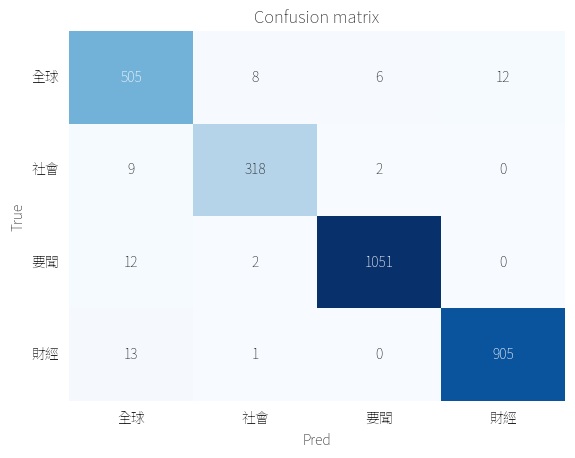

In [136]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [137]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03893692, 0.        , 0.        , 0.08473503, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04536111, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [138]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.95      0.95      0.95       531
          社會       0.96      0.96      0.96       329
          要聞       0.99      0.99      0.99      1065
          財經       0.98      0.98      0.98       919

    accuracy                           0.98      2844
   macro avg       0.97      0.97      0.97      2844
weighted avg       0.98      0.98      0.98      2844



In [139]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 502,    9,    6,   14],
       [   4,  315,    6,    4],
       [  10,    2, 1052,    1],
       [  13,    1,    0,  905]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '社會'),
  Text(0, 2.5, '要聞'),
  Text(0, 3.5, '財經')])

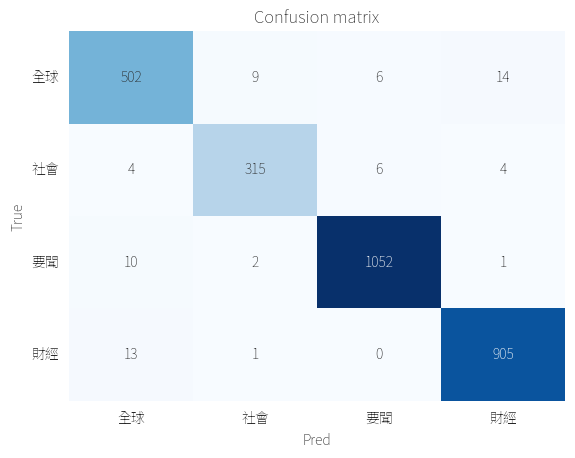

In [140]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

效果一樣也是不錯，可能因為四個新聞版別本來就有很大的差異，用字遣詞會不同。 
故可以有相似成效。

### 3.5 CV  

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。 

* figure1:  

![](images/grid_search_workflow.png) 

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [141]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.10000348, 0.07999945, 0.08499789, 0.08599401, 0.09706163]),
 'score_time': array([0.01500034, 0.01300216, 0.01299834, 0.01399684, 0.01294971]),
 'test_f1_macro': array([0.96350265, 0.95623599, 0.96323367, 0.95730636, 0.96322803]),
 'test_precision_macro': array([0.96653998, 0.95659086, 0.96293366, 0.95995027, 0.96539895]),
 'test_recall_macro': array([0.96077013, 0.95599989, 0.96357226, 0.95490711, 0.961133  ])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [142]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          全球       0.94      0.94      0.94      1264
          社會       0.96      0.94      0.95       767
          要聞       0.99      0.98      0.99      2485
          財經       0.96      0.98      0.97      2119

    accuracy                           0.97      6635
   macro avg       0.96      0.96      0.96      6635
weighted avg       0.97      0.97      0.97      6635



## 4. 比較不同模型效果

In [143]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          全球       0.94      0.94      0.94      1264
          社會       0.96      0.94      0.95       767
          要聞       0.99      0.98      0.99      2485
          財經       0.96      0.98      0.97      2119

    accuracy                           0.97      6635
   macro avg       0.96      0.96      0.96      6635
weighted avg       0.97      0.97      0.97      6635



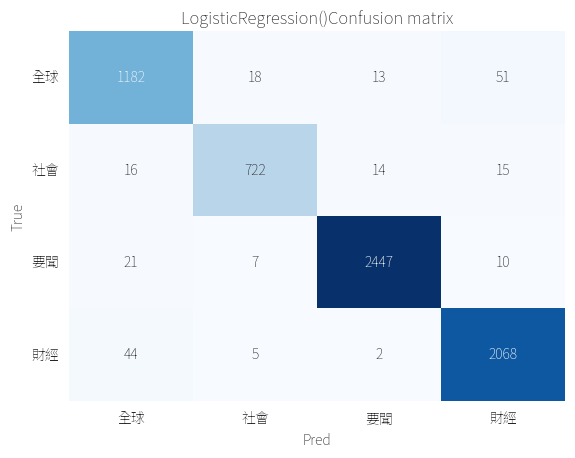

In [144]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          全球       0.94      0.94      0.94      1264
          社會       0.96      0.94      0.95       767
          要聞       0.99      0.98      0.99      2485
          財經       0.96      0.98      0.97      2119

    accuracy                           0.97      6635
   macro avg       0.96      0.96      0.96      6635
weighted avg       0.97      0.97      0.97      6635

now training: clf_dtree
              precision    recall  f1-score   support

          全球       0.83      0.85      0.84      1264
          社會       0.85      0.84      0.85       767
          要聞       0.98      0.98      0.98      2485
          財經       0.94      0.93      0.94      2119

    accuracy                           0.92      6635
   macro avg       0.90      0.90      0.90      6635
weighted avg       0.92      0.92      0.92      6635

now training: clf_svm
              precision    recall  f1-score   support

  

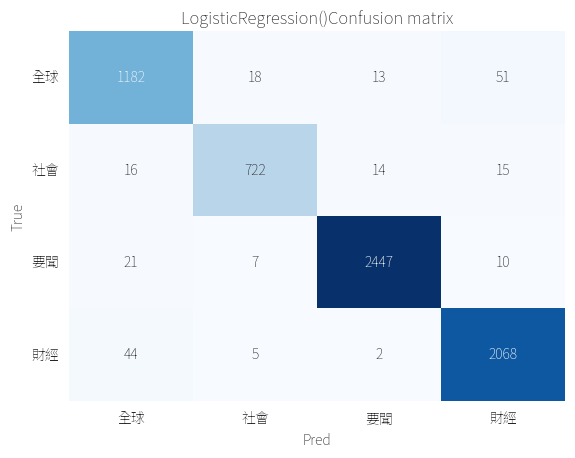

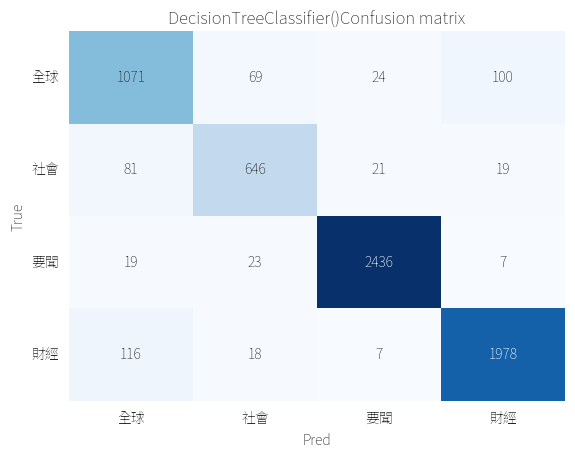

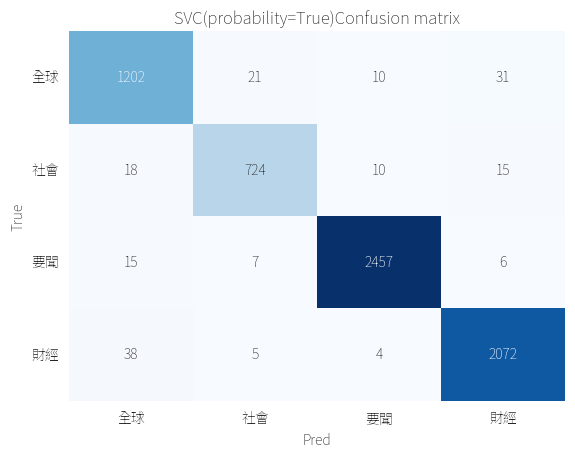

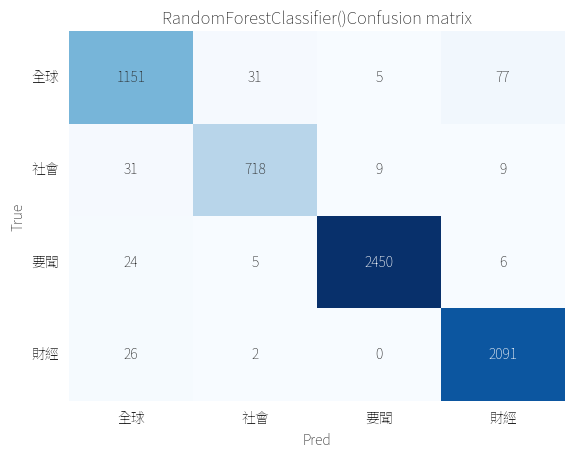

In [145]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [146]:
result_set['clf_logistic']

{'全球': {'precision': 0.9358669833729216,
  'recall': 0.935126582278481,
  'f1-score': 0.9354966363276612,
  'support': 1264.0},
 '社會': {'precision': 0.9601063829787234,
  'recall': 0.9413298565840938,
  'f1-score': 0.9506254114549045,
  'support': 767.0},
 '要聞': {'precision': 0.9882875605815832,
  'recall': 0.9847082494969819,
  'f1-score': 0.9864946583350132,
  'support': 2485.0},
 '財經': {'precision': 0.9645522388059702,
  'recall': 0.975932043416706,
  'f1-score': 0.9702087731644382,
  'support': 2119.0},
 'accuracy': 0.9674453654860588,
 'macro avg': {'precision': 0.9622032914347995,
  'recall': 0.9592741829440656,
  'f1-score': 0.9607063698205043,
  'support': 6635.0},
 'weighted avg': {'precision': 0.9674631868580467,
  'recall': 0.9674453654860588,
  'f1-score': 0.9674316586589341,
  'support': 6635.0}}

In [147]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.972871137905049,
 'macro avg': {'f1-score': 0.965975839675439,
               'precision': 0.9666193696212928,
               'recall': 0.9653597265636197,
               'support': 6635.0},
 'weighted avg': {'f1-score': 0.9728747481058516,
                  'precision': 0.9728937074646966,
                  'recall': 0.972871137905049,
                  'support': 6635.0},
 '全球': {'f1-score': 0.9475758770201025,
        'precision': 0.9442262372348782,
        'recall': 0.9509493670886076,
        'support': 1264.0},
 '社會': {'f1-score': 0.9501312335958005,
        'precision': 0.9564068692206077,
        'recall': 0.9439374185136897,
        'support': 767.0},
 '要聞': {'f1-score': 0.9895287958115183,
        'precision': 0.9903264812575574,
        'recall': 0.9887323943661972,
        'support': 2485.0},
 '財經': {'f1-score': 0.9766674522743342,
        'precision': 0.975517890772128,
        'recall': 0.9778197262859839,
        'support': 2119.0}}


In [148]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.96      0.97      0.96       531
          社會       0.98      0.97      0.97       329
          要聞       0.99      0.99      0.99      1065
          財經       0.99      0.99      0.99       919

    accuracy                           0.98      2844
   macro avg       0.98      0.98      0.98      2844
weighted avg       0.98      0.98      0.98      2844



In [149]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['全球'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [150]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

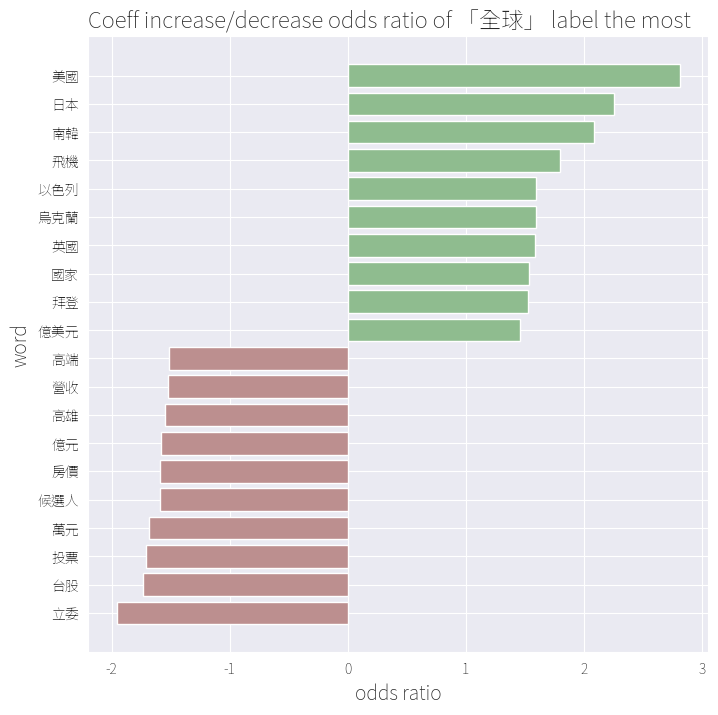

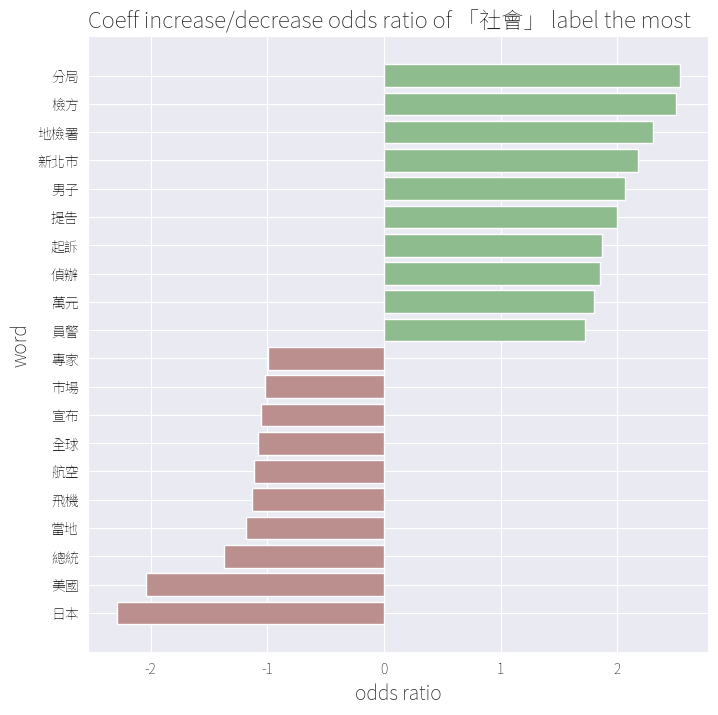

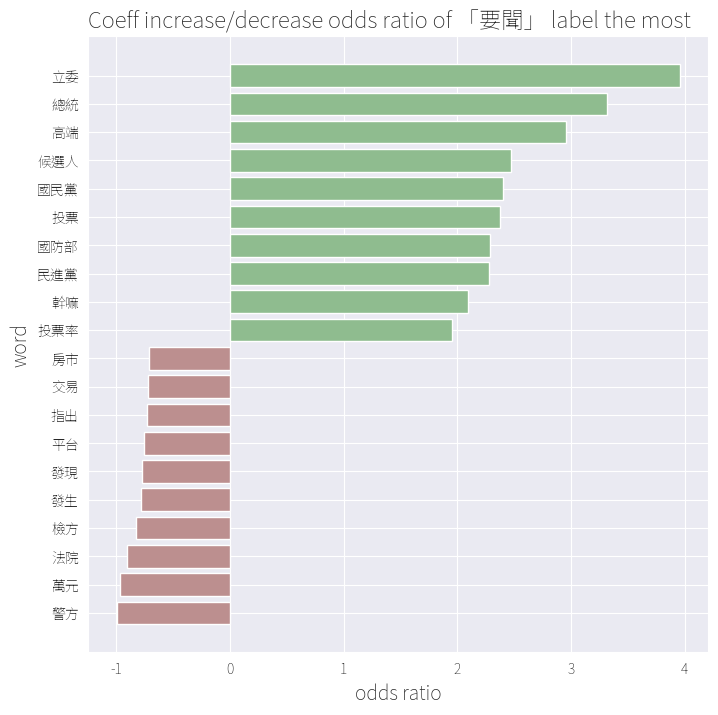

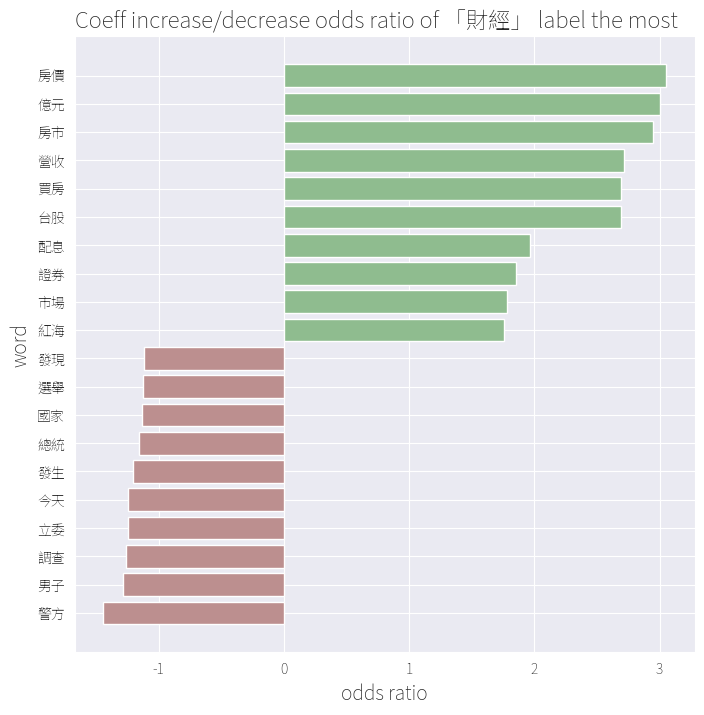

In [151]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

- 「全球」中出現了日本、美國、南韓還有飛機等國際新聞關鍵字，除了國家名稱外，也提到許多元首名稱，比較特殊的是，「飛機」這個詞語也被廣泛使用，經過查看資料發現國際新聞中常提到飛機相關的新聞，其中很多是描述共機擾台事件，此外還有關於日籍遊客輕航機失事等新聞。
- 「社會」中高係數的字是分局、檢方、地檢署等字詞，這些字詞通常出現在社會新聞中，例如檢方偵辦案件、地檢署提起公訴等相關新聞。此外，比較特殊是有提到「萬元」這個詞詞彙，經觀察資料，期出現在房價，以及罰鍰與獎金上。在此之上出現了「新北市」與「男子」，說明在此段時間內新北市的社會新聞中，有男子相關的社會案件。
- 「要聞」中高係數的字是立委、總統、高端與候選人，除了常見的政治相關詞彙外，我們發現有個看似不相干詞彙「幹嘛」，經觀察資料，發現這個詞彙幾乎都來自「政黨票能幹嘛？4神秘數字搶席次、領補助、還可扣稅」與「選民抱不平：幹嘛蹚這趟渾水？」等新聞，前者來自一個懶人包文字描述，後者則是來自一個影片的標題。
- 「財經」則是房市、億元、房價、營收與台股等相關詞彙，只會出現在財經相關新聞上，但是我發現「透天」這個詞彙也出現在財經新聞中，經觀察資料，發現該資料不僅出現在財經，也出現在多個新聞版面，因此我們決定將其加入停用字中。經過修改後，詞彙都更專注在財經術語上。

## 6. 預測新聞類別

`東森新聞.csv` 為東森新聞資料
- 版別：國際(world)、社會(society)、政治(politics)、財經(ec)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無

In [152]:
ct = pd.read_csv("data/東森新聞.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,她勞保多繳4年！少領近57萬 問題竟出在最後3年｜東森新聞,https://news.ebc.net.tw/news/article/397623,2023-12-24 10:59:00,財經,一名擁有26年年資的女性上班族，4年前離職退保，原本一次領可領169.46萬元，後來離職接案，卻選擇加入職業工會，以最低薪資2.5萬元繼續投保，最後少領了近57萬。對此，勞保達人張秘書也做出解釋。YouTube頻道「勞工朋友的祕書～張秘書」在一則影片中分享一個案例，一名52歲勞工年資26年，因職業倦怠不想再朝九晚五，決定改在家接案工作，她雖已符合一次領的資格，卻選擇加入職業工會，加保4年。張秘書以這個例子試算，經過四年的職業工會加保，當小倩決定請領一次給付年金時，卻發現因為最後三年的平均投保薪資僅為2.5萬元，按照勞保局的規定，一次請領的給付金額相對較低，25000元×45個基數＝1125000元。如果小倩當初選擇直接一次請領，擁有26年年資的她可以按照37個基數計算，而最終的給付金額高達169.46萬元，45800元×37個基數＝1694600元。也就是說，小倩勞保多繳4年，反而少領了56萬9600元。張秘書強調，如果勞工選擇一次請領老年給付，務必注意最後3年的投保資薪必須保持在最高水平，否則可能會得不償失。一、必須是離職退保狀態下。二、平均月投保薪資是取最後3年。三、基數算法，前15年一年一個基數，第16年開始每年算二個基數。四、60歲以前年資上限是30年。五、年資未滿30日，以一個月計算。一、保險年資合計每滿1年，按其平均月投保薪資發給1個月。二、保險年資合計超過15年者，超過部分，每滿1年發給2個月，最高以45個月為限。例如：年資26年，其給付年資15+22＝37（個基數）。三、被保險人逾60歲繼續工作者，其逾60歲以後之保險年資，最多以5年計，合併60歲以前之一次請領老年給付，最高以50個月為限。,EBC
1,2,她薪水全丟這！存百萬竟遭18歲表弟嗆：不如阿公那輩｜東森新聞,https://news.ebc.net.tw/news/article/397656,2023-12-24 14:16:00,財經,面對低薪，除了斜槓，大家也會選擇投資。一名女網友表示，才高中的表弟嘲笑她只懂存錢，投資理財的等級比阿公那輩還不如，讓她開始想要改變。原PO在Dcard指出，因為父母沒有投資的習慣，家庭教育也一直跟她反覆告誡投資有風險，股票可能會讓人賠到跳樓，所以長大賺了錢也只會存起來，甚至直到前年才知道一樣是存錢，存到實體開戶的銀行，跟存到數位帳戶利息差很多，所以薪水都是每月固定轉Bankee領利息。原PO透露，親戚聚會的時候聊到理財，才發現現在的高中生都很有想法，也敢於付諸行動，明明還沒出社會賺錢，但賺錢的方法很多，才18歲已經看好要買哪支股票，「表弟問我買股票有沒有賺錢，我說沒有買後，還被他嘲諷，說我只懂存錢，投資理財的等級比阿公那輩還不如，阿公30年前都知道買股票、固定領股息，我這樣根本不算現代人，還是趕快找個有錢男人嫁了。」原PO附上近200萬的存款嘆，平時會逛理財板，看到很多人分享自己千萬存款或幾歲存到百萬，其實覺得很羨慕，也想改變，「2024年開始想要開始投資一點股票，或者多做點副業增加收入，目前已經有申請證券開戶了，不曉得大家有沒有推薦的。」貼文一出，不少人紛紛留言「不會覺得自己比沒買股票的人厲害，任何事情只要想開始都不嫌晚，ETF自己慢慢爬文，投資不要隨意相信他人」、「沒有說存銀行就是不好的投資，投資確實也有風險，不懂理財穩穩存銀行也不吃虧」、「股票也可能賠錢，你這樣列，感覺太理想了」。文章來源：她拿到薪水全丟這⋯「百萬存款」曝光18歲表弟酸：比阿公那輩還不如由CTWANT授權轉載。,EBC
2,3,陽明海運年終落差超嚴重！去年13個月 今年數字嚇死人｜東森新聞,https://news.ebc.net.tw/news/article/397802,2023-12-25 12:13:00,財經,在疫情期間，航運相關產業可以說是獲利頗豐，陽明海運在2022年的年終就高達13個月，羨煞不少民眾。但現在有消息指出，陽明海運於日前召開董事會，決議今年年終獎金僅1個月，加上每年固定的第13個月薪資，形同年終獎金僅2個月，與去年相比有著不少的落差。據了解，陽明海運去年年終有13個月，2023年的年度分紅也有20個月，整個加起來多達33個月之多。但根據媒體報導指出，在陽明海運的董事會上，決議年終獎金僅有1個月。而報導中也推估2024年的年終分紅也僅有1個月，加上固定的第13個月薪資，總和僅3.2個月。但好消息是，陽明海運將比照公務員標準，明年為員工加薪4%。報導中也提到，由於陽明海運具有官股性質，年終獎金最多只能發12個月，但是在分紅制度方面，陽明海運明訂稅前獲利1%為員工紅利，這數字遠高於長榮海運的0.5%與萬海的0.6%。,EBC
3,4,勞保紓困貸款最高拿10萬元 申請4條件曝光！｜東森新聞,https://news.ebc.net.tw/news/article/397804,2023-12-25 13:02:00,財經,勞工快看過來！今（25）日，勞動部公告113年勞保紓困貸款將在1月5日開放申請，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，其也列出貸款申貸資格4條件，若有符合資格的勞工，記得於受理時間申請。勞動部表示，為了要協助勞工朋友度過農曆年前經濟困難，113年勞保紓困貸款將於113年1月5日正式開辦，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，年利率目前為2.04％，前6個月按月付息不還本，第7個月起按月平均攤還本息。1.生活困難需要紓困2.參加勞工保險年資滿15年（計算至受理截止日113年1月19日止）3.無欠繳勞工保險費及滯納金4.未曾借貸勞保紓困貸款，或曾借貸已繳清貸款本金及利息者勞動部指出，若是已請領老年給付、終身無工作能力之失能給付或向其所屬機關請領勞工保險補償金者，則不得申請勞保紓困貸款。申辦本項貸款無需繳交任何費用；每人限申請1次，重複申請者不予受理。另外，符合資格且有需求之勞工朋友，可以於受理申請期間，透過網路、臨櫃或郵寄等方式，向土地銀行各地分行或其委託之金融機構提出申請。對此，勞動部也呼籲，為了減少民眾臨櫃排隊久候時間，請多加利用網路申請，例假日亦可使用，既省時又方便。此外，勞動部勞工保險局在2023年的尾聲，將陸續完成11項給付的入帳作業，預計今日發放國民年金保險老年基本保證年金、國民年金保險原住民給付；周四（28日）則預計發放勞保年金給付、職保年金給付、勞退月退休金（首發案）。周五（29日）將有另外6項給付入帳，包括產檢假與陪產檢及陪產假薪資補助、國保身心障礙年金給付併計勞保年資、國民年金保險老年年金給付、國民年金保險身心障礙（基本保證）年金、國民年金保險喪葬給付、國民年金保險遺囑年金。詳情請治土地銀行客服專線（02）2314-6633及其所屬分行或其委託金融機構，土地銀行於連江縣馬祖地區無營業據點，委託連江縣農會受理；或電洽勞保局服務專線（02）2396-1266。,EBC
4,5,台塑四寶獲利衰！年終3.5個月恐無望 創11年低｜東森新聞,https://news.ebc.net.tw/news/article/397811,2023-12-25 13:51:00,財經,舞台上辣妹勁歌熱舞，炒熱現場氣氛，年底員工最期待的就是年終尾牙，不過傳產龍頭台塑集團，考量剛搬遷到內湖新總部，今年尾牙還是再度停辦，而年終獎金恐怕還會讓員工小失望，因為可能創下近11年最低，不到3.5個月。台塑企業全國聯合會理事長陳鴻儒：「外界所傳的要（EPS）2.43元，（年終）才能達到3.5個月，好在是說公司跟工會有做一個協商，最低保障是3個月，最高7個月。」攤開歷年台塑年終大紅包，110年獲利爆發，員工年終領到最高上限7個月，羨煞不少人，但去年開始受到國際油價、石化行情趨緩影響，略為縮水，而今年可能不只保不了3.5個月，就連工會想積極爭取的3.3個月，恐怕也很艱難。財經專家邱敏寬：「台塑四寶在年底的時候，又遭遇到整個EAFC當中的特殊產品限制，那就目前來說，這個限制到選後會不會開放，要持續來做觀察。」尤其在通膨升息壓力干擾下，讓中國大陸經濟復甦不如預期，即使第三季油價強彈，但台塑四寶前三季稅後純益，仍是452億元年減60.8％，財經專家邱敏寬：「明年的經濟成長率，目前七大機構來估，大概都有到3％以上，今年對台塑四寶相對比較保守，但是我對於明年倒是會比較樂觀一些，因為明年的傳統產業跟電子產業，特別是在通訊跟AI這一塊，擴張性會比較大一點。」不過明年台塑是否將會出現變動，資深媒體人臉書及內部員工，都爆出明年台塑四寶將有人事大地震，但台塑集團對相關謠言皆不予置評，要專注在公司營運，期許在新的一年，能繼續全力衝刺。,EBC
...,...,...,...,...,...,...,...
1775,1776,美英轟葉門叛軍 油價飆漲4％貨櫃運價連7漲｜東森新聞,https://news.ebc.net.tw/news/article/400727,2024-01-13 08:00:00,國際,美英聯軍12日針對葉門叛軍青年運動的73處目標，發射至少一百五十枚「戰斧」巡弋飛彈及雷射導引炸彈。轟炸葉門叛軍青年運動的73處目標。紅海局勢升高，造成貨櫃運價連七漲，原油價格也

In [153]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,她勞保多繳4年！少領近57萬 問題竟出在最後3年｜東森新聞一名擁有26年年資的女性上班族，4年前離職退保，原本一次領可領169.46萬元，後來離職接案，卻選擇加入職業工會，以最低薪資2.5萬元繼續投保，最後少領了近57萬。對此，勞保達人張秘書也做出解釋。YouTube頻道「勞工朋友的祕書～張秘書」在一則影片中分享一個案例，一名52歲勞工年資26年，因職業倦怠不想再朝九晚五，決定改在家接案工作，她雖已符合一次領的資格，卻選擇加入職業工會，加保4年。張秘書以這個例子試算，經過四年的職業工會加保，當小倩決定請領一次給付年金時，卻發現因為最後三年的平均投保薪資僅為2.5萬元，按照勞保局的規定，一次請領的給付金額相對較低，25000元×45個基數＝1125000元。如果小倩當初選擇直接一次請領，擁有26年年資的她可以按照37個基數計算，而最終的給付金額高達169.46萬元，45800元×37個基數＝1694600元。也就是說，小倩勞保多繳4年，反而少領了56萬9600元。張秘書強調，如果勞工選擇一次請領老年給付，務必注意最後3年的投保資薪必須保持在最高水平，否則可能會得不償失。一、必須是離職退保狀態下。二、平均月投保薪資是取最後3年。三、基數算法，前15年一年一個基數，第16年開始每年算二個基數。四、60歲以前年資上限是30年。五、年資未滿30日，以一個月計算。一、保險年資合計每滿1年，按其平均月投保薪資發給1個月。二、保險年資合計超過15年者，超過部分，每滿1年發給2個月，最高以45個月為限。例如：年資26年，其給付年資15+22＝37（個基數）。三、被保險人逾60歲繼續工作者，其逾60歲以後之保險年資，最多以5年計，合併60歲以前之一次請領老年給付，最高以50個月為限。,https://news.ebc.net.tw/news/article/397623,財經,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 年前 離職 退保 原本 一次 領可領 169.46 萬元 離職 接案 選擇 加入 職業工會 最低 薪資 2.5 萬元 繼續 投保 最後 少領 57 對此 勞保 達人 張秘 做出 解釋 YouTube 頻道 勞工 朋友 祕書 張秘書 影片 分享 案例 一名 52 勞工 年資 26 職業倦怠 不想 朝九晚五 決定 在家 接案 工作 符合 一次 領的 資格 選擇 加入 職業工會 加保 秘書以 例子 試算 四年 職業工會 加保 當小倩 決定 請領 一次 給付 年金 發現 最後 三年 平均 投保 薪資 僅為 2.5 萬元 勞保局 規定 一次 請領 給付 金額 相對 25000 45 基數 1125000 小倩 當初 選擇 直接 一次 請領 擁有 26 年資 37 基數 計算 最終 給付 金額 高達 169.46 萬元 45800 37 基數 1694600 也就是說 小倩 勞保 多繳 少領 56 9600 張秘書 強調 勞工 選擇 一次 請領 老年 給付 務必 注意 最後 投保 資薪 保持 最高 水平 得不償失 離職 退保 狀態 平均 投保 薪資 最後 基數 算法 15 一年 基數 16 每年 二個 基數 60 以前 年資 上限 30 年資 未滿 30 一個月 計算 年資 合計 每滿 平均 投保 薪資 發給 年資 合計 超過 15 年者 超過 部分 每滿 發給 最高 45 年資 26 給付 年資 15 22 37 基數 被保險人 60 繼續 工作者 60 以後 年資 最多以 年計 合併 60 以前 一次 請領 老年 給付 最高 50
1,她薪水全丟這！存百萬竟遭18歲表弟嗆：不如阿公那輩｜東森新聞面對低薪，除了斜槓，大家也會選擇投資。一名女網友表示，才高中的表弟嘲笑她只懂存錢，投資理財的等級比阿公那輩還不如，讓她開始想要改變。原PO在Dcard指出，因為父母沒有投資的習慣，家庭教育也一直跟她反覆告誡投資有風險，股票可能會讓人賠到跳樓，所以長大賺了錢也只會存起來，甚至直到前年才知道一樣是存錢，存到實體開戶的銀行，跟存到數位帳戶利息差很多，所以薪水都是每月固定轉Bankee領利息。原PO透露，親戚聚會的時候聊到理財，才發現現在的高中生都很有想法，也敢於付諸行動，明明還沒出社會賺錢，但賺錢的方法很多，才18歲已經看好要買哪支股票，「表弟問我買股票有沒有賺錢，我說沒有買後，還被他嘲諷，說我只懂存錢，投資理財的等級比阿公那輩還不如，阿公30年前都知道買股票、固定領股息，我這樣根本不算現代人，還是趕快找個有錢男人嫁了。」原PO附上近200萬的存款嘆，平時會逛理財板，看到很多人分享自己千萬存款或幾歲存到百萬，其實覺得很羨慕，也想改變，「2024年開始想要開始投資一點股票，或者多做點副業增加收入，目前已經有申請證券開戶了，不曉得大家有沒有推薦的。」貼文一出，不少人紛紛留言「不會覺得自己比沒買股票的人厲害，任何事情只要想開始都不嫌晚，ETF自己慢慢爬文，投資不要隨意相信他人」、「沒有說存銀行就是不好的投資，投資確實也有風險，不懂理財穩穩存銀行也不吃虧」、「股票也可能賠錢，你這樣列，感覺太理想了」。文章來源：她拿到薪水全丟這⋯「百萬存款」曝光18歲表弟酸：比阿公那輩還不如由CTWANT授權轉載。,https://news.ebc.net.tw/news/article/397656,財經,薪水 百萬 18 表弟 阿公 那輩 東森 新聞 面對 低薪 斜槓 選擇 投資 一名 女網友 表示 高中 表弟 嘲笑 存錢 投資 理財 等級 阿公 那輩還 想要 改變 PO Dcard 指出 父母 投資 習慣 家庭教育 一直 反覆 告誡 投資 風險 股票 賠到 跳樓 長大 賺了錢 只會存 直到 前年 知道 存錢 實體 開戶 銀行 存到 數位 帳戶 利息 薪水 每月 固定 Bankee 利息 PO 透露 親戚 聚會 聊到 理財 發現 現在 高中生 想法 付諸行動 明明 還沒出 社會 賺錢 賺錢 方法 18 已經 看好 哪支 股票 表弟 問我 股票 有沒有 賺錢 還被 嘲諷 存錢 投資 理財 等級 阿公 那輩還 阿公 30 年前 知道 股票 固定 股息 根本 不算 現代人 找個 有錢 男人 PO 附上 200 存款 平時 理財 看到 分享 存款 幾歲 百萬 覺得 羨慕 改變 2024 想要 投資 一點 股票 做點 副業 增加收入 目前 已經 申請 證券 開戶 曉得 有沒有 推薦 貼文 一出 紛紛 留言 覺得 股票 厲害 事情 ETF 慢慢 爬文 投資 隨意 相信 說存 銀行 不好 投資 投資 確實 風險 理財 穩穩 銀行 吃虧 股票 賠錢 感覺 理想 文章 來源 拿到 薪水 百萬 存款 曝光 18 表弟 阿公 那輩還 CTWANT 授權 轉載
2,陽明海運年終落差超嚴重！去年13個月 今年數字嚇死人｜東森新聞在疫情期間，航運相關產業可以說是獲利頗豐，陽明海運在2022年的年終就高達13個月，羨煞不少民眾。但現在有消息指出，陽明海運於日前召開董事會，決議今年年終獎金僅1個月，加上每年固定的第13個月薪資，形同年終獎金僅2個月，與去年相比有著不少的落差。據了解，陽明海運去年年終有13個月，2023年的年度分紅也有20個月，整個加起來多達33個月之多。但根據媒體報導指出，在陽明海運的董事會上，決議年終獎金僅有1個月。而報導中也推估2024年的年終分紅也僅有1個月，加上固定的第13個月薪資，總和僅3.2個月。但好消息是，陽明海運將比照公務員標準，明年為員工加薪4%。報導中也提到，由於陽明海運具有官股性質，年終獎金最多只能發12個月，但是在分紅制度方面，陽明海運明訂稅前獲利1%為員工紅利，這數字遠高於長榮海運的0.5%與萬海的0.6%。,https://news.ebc.net.tw/news/article/397802,財經,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 相關 產業 獲利 頗豐 陽明 海運 2022 年終 高達 13 羨煞 民眾 現在 消息 指出 陽明 海運 日前 召開 董事會 決議 今年 年終獎金 每年 固定 13 薪資 形同 年終獎金 去年 相比 有著 落差 了解 陽明 海運 去年 年終 13 2023 年度 分紅 20 整個 多達 33 媒體 指出 陽明 海運 董事會 決議 年終獎金 僅有 推估 2024 年終 分紅 僅有 固定 13 薪資 總和 3.2 好消息 陽明 海運 公務員 標準 明年 員工 加薪 4% 提到 陽明 海運 具有 官股 性質 年終獎金 只能 12 分紅 制度 方面 陽明 海運 明訂 稅前 獲利 1% 員工 紅利 數字 遠高於 長榮 海運 0.5% 萬海 0.6%
3,勞保紓困貸款最高拿10萬元 申請4條件曝光！｜東森新聞勞工快看過來！今（25）日，勞動部公告113年勞保紓困貸款將在1月5日開放申請，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，其也列出貸款申貸資格4條件，若有符合資格的勞工，記得於受理時間申請。勞動部表示，為了要協助勞工朋友度過農曆年前經濟困難，113年勞保紓困貸款將於113年1月5日正式開辦，受理至113年1月19日截止，每人最高可貸10萬元，貸款期間3年，年利率目前為2.04％，前6個月按月付息不還本，第7個月起按月平均攤還本息。1.生活困難需要紓困2.參加勞工保險年資滿15年（計算至受理截止日113年1月19日止）3.無欠繳勞工保險費及滯納金4.未曾借貸勞保紓困

In [155]:
ct['artCatagory'].value_counts()

artCatagory
政治    660
社會    622
國際    451
財經     47
Name: count, dtype: int64

In [156]:
mapper = {"政治":"要聞", "國際":"全球", "社會":"社會", "財經":"財經"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          全球       0.78      0.92      0.84       451
          社會       0.89      0.90      0.90       622
          要聞       0.99      0.86      0.92       660
          財經       0.57      0.55      0.56        47

    accuracy                           0.88      1780
   macro avg       0.81      0.81      0.80      1780
weighted avg       0.89      0.88      0.88      1780



In [157]:
classes = clf.classes_
cm = confusion_matrix(y, y_pred)
cm

array([[414,  26,   4,   7],
       [ 54, 559,   3,   6],
       [ 42,  41, 570,   7],
       [ 20,   1,   0,  26]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '社會'),
  Text(0, 2.5, '要聞'),
  Text(0, 3.5, '財經')])

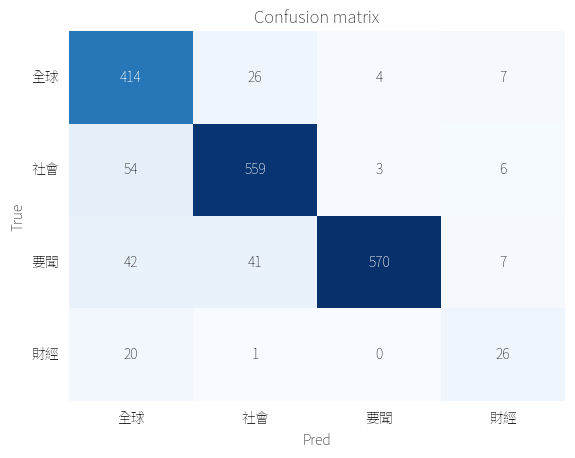

In [158]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [159]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 年前 離職 退保 原本 一次 領可領 169.46 萬元 離職 接案 選擇 加入 職業工會 最低 薪資 2.5 萬元 繼續 投保 最後 少領 57 對此 勞保 達人 張秘 做出 解釋 YouTube 頻道 勞工 朋友 祕書 張秘書 影片 分享 案例 一名 52 勞工 年資 26 職業倦怠 不想 朝九晚五 決定 在家 接案 工作 符合 一次 領的 資格 選擇 加入 職業工會 加保 秘書以 例子 試算 四年 職業工會 加保 當小倩 決定 請領 一次 給付 年金 發現 最後 三年 平均 投保 薪資 僅為 2.5 萬元 勞保局 規定 一次 請領 給付 金額 相對 25000 45 基數 1125000 小倩 當初 選擇 直接 一次 請領 擁有 26 年資 37 基數 計算 最終 給付 金額 高達 169.46 萬元 45800 37 基數 1694600 也就是說 小倩 勞保 多繳 少領 56 9600 張秘書 強調 勞工 選擇 一次 請領 老年 給付 務必 注意 最後 投保 資薪 保持 最高 水平 得不償失 離職 退保 狀態 平均 投保 薪資 最後 基數 算法 15 一年 基數 16 每年 二個 基數 60 以前 年資 上限 30 年資 未滿 30 一個月 計算 年資 合計 每滿 平均 投保 薪資 發給 年資 合計 超過 15 年者 超過 部分 每滿 發給 最高 45 年資 26 給付 年資 15 22 37 基數 被保險人 60 繼續 工作者 60 以後 年資 最多以 年計 合併 60 以前 一次 請領 老年 給付 最高 50,財經,財經
1,薪水 百萬 18 表弟 阿公 那輩 東森 新聞 面對 低薪 斜槓 選擇 投資 一名 女網友 表示 高中 表弟 嘲笑 存錢 投資 理財 等級 阿公 那輩還 想要 改變 PO Dcard 指出 父母 投資 習慣 家庭教育 一直 反覆 告誡 投資 風險 股票 賠到 跳樓 長大 賺了錢 只會存 直到 前年 知道 存錢 實體 開戶 銀行 存到 數位 帳戶 利息 薪水 每月 固定 Bankee 利息 PO 透露 親戚 聚會 聊到 理財 發現 現在 高中生 想法 付諸行動 明明 還沒出 社會 賺錢 賺錢 方法 18 已經 看好 哪支 股票 表弟 問我 股票 有沒有 賺錢 還被 嘲諷 存錢 投資 理財 等級 阿公 那輩還 阿公 30 年前 知道 股票 固定 股息 根本 不算 現代人 找個 有錢 男人 PO 附上 200 存款 平時 理財 看到 分享 存款 幾歲 百萬 覺得 羨慕 改變 2024 想要 投資 一點 股票 做點 副業 增加收入 目前 已經 申請 證券 開戶 曉得 有沒有 推薦 貼文 一出 紛紛 留言 覺得 股票 厲害 事情 ETF 慢慢 爬文 投資 隨意 相信 說存 銀行 不好 投資 投資 確實 風險 理財 穩穩 銀行 吃虧 股票 賠錢 感覺 理想 文章 來源 拿到 薪水 百萬 存款 曝光 18 表弟 阿公 那輩還 CTWANT 授權 轉載,財經,財經
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 相關 產業 獲利 頗豐 陽明 海運 2022 年終 高達 13 羨煞 民眾 現在 消息 指出 陽明 海運 日前 召開 董事會 決議 今年 年終獎金 每年 固定 13 薪資 形同 年終獎金 去年 相比 有著 落差 了解 陽明 海運 去年 年終 13 2023 年度 分紅 20 整個 多達 33 媒體 指出 陽明 海運 董事會 決議 年終獎金 僅有 推估 2024 年終 分紅 僅有 固定 13 薪資 總和 3.2 好消息 陽明 海運 公務員 標準 明年 員工 加薪 4% 提到 陽明 海運 具有 官股 性質 年終獎金 只能 12 分紅 制度 方面 陽明 海運 明訂 稅前 獲利 1% 員工 紅利 數字 遠高於 長榮 海運 0.5% 萬海 0.6%,財經,全球
3,勞保 貸款 最高 10 萬元 申請 條件 曝光 東森 新聞 勞工 過來 25 勞動部 公告 113 勞保 貸款 將在 開放 申請 受理 113 19 截止 每人 最高 可貸 10 萬元 貸款 期間 列出 貸款 申貸 資格 條件 若有 符合 資格 勞工 記得 受理 時間 申請 勞動部 表示 協助 勞工 朋友 度過 農曆 年前 經濟 困難 113 勞保 貸款 將於 113 正式 開辦 受理 113 19 截止 每人 最高 可貸 10 萬元 貸款 期間 年利率 目前 2.04 付息 還本 平均 攤還 本息 生活 困難 需要 參加 勞工保險 年資 15 計算 受理 截止日 113 19 日止 欠繳 勞工 保險費 滯納金 未曾 借貸 勞保 貸款 借貸 繳清 貸款 本金 利息 勞動部 指出 請領 老年 給付 終身 工作 能力 之失 給付 所屬 機關 請領 勞工保險 補償金 申請 勞保 貸款 申辦 本項 貸款 無需 繳交 費用 每人 申請 重複 申請者 不予 受理 符合 資格 需求 勞工 朋友 受理 申請 期間 透過 網路 臨櫃 郵寄 方式 土地銀行 各地 分行 委託 金融機構 提出申請 對此 勞動部 呼籲 減少 民眾 臨櫃 排隊 久候 時間 請多加 利用 網路 申請 例假日 亦可 使用 既省 方便 勞動部 勞工保險 局在 2023 尾聲 陸續 完成 11 給付 入帳 作業 預計 發放 國民 年金 老年 保證 年金 國民 年金 原住民 給付 周四 28 預計 發放 勞保 年金 給付 職保 年金 給付 勞退 退休金 首發 周五 29 將有 給付 入帳 包括 產檢假 陪產 檢及 產假 薪資 補助 國保 身心 障礙 年金 給付 勞保 年資 國民 年金 老年 年金 給付 國民 年金 身心 障礙 保證 年金 國民 年金 喪葬 給付 國民 年金 遺囑 年金 詳情請 土地銀行 客服 專線 02 2314 6633 所屬 分行 委託 金融機構 土地銀行 連江縣 馬祖地區 營業 據點 委託 連江縣 農會 受理 電洽 勞保局 服務 專線 02 2396 1266,財經,財經
4,台塑 四寶 獲利 年終 3.5 無望 11 東森 新聞 舞台 辣妹 勁歌熱舞 炒熱 現場 氣氛 年底 員工 期待 年終 尾牙 傳產 龍頭 台塑 集團 考量 搬遷 內湖 總部 今年 尾牙 再度 停辦 年終獎金 還會 員工 失望 創下 11 最低 不到 3.5 台塑 企業 全國 聯合會 理事長 鴻儒 外界 所傳 EPS 2.43 年終 達到 3.5 公司 工會 協商 最低 保障 最高 攤開 歷年 台塑 年終 大紅包 110 獲利 爆發 員工 年終 領到 最高 上限 羨煞 去年 受到 國際 油價 石化 行情 趨緩 影響 縮水 今年 3.5 就連 工會 積極爭取 3.3 艱難 財經專家 邱敏 台塑 四寶在 年底 遭遇 整個 EAFC 特殊 產品 限制 目前 來說 限制 選後會 開放 持續 觀察 尤其 升息 壓力 干擾 中國 大陸 經濟 復甦 預期 第三季 油價 強彈 台塑 四寶 前三季 稅後 純益 452 億元 年減 60.8 財經專家 邱敏 明年 經濟 成長率 目前 七大 機構 來估 以上 今年 台塑 四寶 相對 比較 保守 明年 比較 樂觀 一些 明年 傳統產業 電子 產業 特別是在 通訊 AI 一塊 擴張性 比較 一點 明年 台塑 是否 將會 出現 變動 資深 媒體 人臉 書及 內部 員工 爆出 明年 台塑 四寶將 有人 事大 地震 台塑 集團 相關 謠言 不予置評 專注 公司 營運 期許 一年 繼續 衝刺,財經,財經
...,...,...,...
1775,美英 葉門 叛軍 油價 飆漲 貨櫃 運價 東森 新聞 美英 聯軍 12 針對 葉門 叛軍 青年運動 73 目標 發射 至少 一百五十 戰斧 巡弋 飛彈 雷射 導引 炸彈 轟炸 葉門 叛軍 青年運動 73 目標 紅海 局勢 升高 造成 貨櫃 運價 連七漲 原油價格 一天 飆漲 4% 夜色 美軍 F18 戰機 艾森豪 航空母艦 升空 打擊 葉門 叛軍 青年運動 據點 英國 颱風 戰機 塞普路斯 起飛 進行 攻擊 參與 軍事行動 協力 國家 包括 澳洲 巴林 加拿大 荷蘭 美國國防部 發言人 萊德 這是 國際 問題 需要 國際 社會 共同 解決 當地 時間 12 凌晨 英美 聯軍 發射 包括 戰斧 飛彈 超過 一百五十 精準 導引 彈藥 攻擊 伊朗 支持 青年運動 叛軍 葉門 首都 地點 73 目標 目的 削弱 青年運動 去年底 以來 宣稱 支持 薩哈 瑪斯 紅海 商船 攻擊 武力 美國 總統 拜登 我己 經向 伊朗 傳遞 訊息 知道 所欲 拜登 表示 伊朗 代理人 戰爭 對此 青年運動 進行 反擊 至少 發射 飛彈 擊中 船艦 青年運動 揚言 繼續 攻擊 紅海 商船 首都 那則 出現 大規模 反美 以色列 抗議 數萬人 湧上 首都 街頭 遊行 焚燒 國旗 洩憤 伊朗 公布 11 號在 阿曼灣 扣押 一艘 美國 油輪 畫面 伊朗 表示 這項 行動 報復 美國 去年 扣押 一艘船 石油 紅海 局勢 升溫 造成 油價 波動 布蘭特 北海 原油 西德 中級 原油 十二日 價格 飆漲 貨櫃 運價 指數 攀高 最新 一期 上海 出口 集裝箱 運價 指數 大漲 309.38 點至 2206.03 站上 2000 大關 英美 聯軍 攻擊 葉門 叛軍 引發 疑慮 卡達 阿曼 美國 波斯灣 盟邦 擔憂 區域 

In [161]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 相關 產業 獲利 頗豐 陽明 海運 2022 年終 高達 13 羨煞 民眾 現在 消息 指出 陽明 海運 日前 召開 董事會 決議 今年 年終獎金 每年 固定 13 薪資 形同 年終獎金 去年 相比 有著 落差 了解 陽明 海運 去年 年終 13 2023 年度 分紅 20 整個 多達 33 媒體 指出 陽明 海運 董事會 決議 年終獎金 僅有 推估 2024 年終 分紅 僅有 固定 13 薪資 總和 3.2 好消息 陽明 海運 公務員 標準 明年 員工 加薪 4% 提到 陽明 海運 具有 官股 性質 年終獎金 只能 12 分紅 制度 方面 陽明 海運 明訂 稅前 獲利 1% 員工 紅利 數字 遠高於 長榮 海運 0.5% 萬海 0.6%,財經,全球
5,元老 振榮 辭世 業界 緬懷 生前 海派 人緣 東森 新聞 中鋼前 總經理 振榮 參與 公司 階段 擴建 歷程 業界 享有 聲譽 晚年 飽受 癌症 摧殘 住進 安寧 病房 25 凌晨 辭世 享壽 77 令人 不勝唏噓 振榮 出生 高雄 鳳山 礦冶 畢業 考進 中鋼 出身 政治 世家 叔叔 義秋 外號 鳳山 政商 實力雄厚 政治 一途 1990 年代 擔任 總經理 中鋼 黃埔 一期 員工 基層 做起 一晃眼 12 民營化 過程 人脈 帶領 團隊 立法院 朝野 溝通 中鋼 國營 轉為 民營 慢慢 奠定 基礎 成為 台灣 最大 鋼鐵企業 振榮 傳出 病逝 各界 紛紛 緬懷 幹部 口吃 喝酒 我弟 豪邁 性格 印象 深刻 稱讚 對方 性情中人 喜歡 交朋友 公司 公關 經他 之手 順遂 公司 基層 親切 幹部 嚴格 幹部 以身作則 鋼鐵 回憶 振榮 當年 帶領 民營化 難能可貴 創造 時代 交棒給 下一代 翁朝棟 帶領 創下 建廠 50 年來 最高 營運 獲利 績效 振榮 退休 每次 提到 此事 有榮 傑出 幹部 拍胸脯 大聲 振榮 永遠 長官 文章 來源 中鋼前 總座 振榮 辭世 享壽 77 業界 緬懷 生前 海派 人緣 CTWANT 授權 轉載,財經,全球
10,美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 政府 選擇 否決 專利 侵權 裁定 蘋果公司 Apple 今天 表示 旗下 智慧 手錶 AppleWatch 最新型 號的 進口 禁令 提起 上訴 綜合 法新社 路透社 這項 針對 蘋果 最新 智慧 手錶 型號 禁令 今天 生效 AppleWatchSeries9 AppleWatchUltra2 無法 美國 實體 商店 或線 銷售 這項 禁令 大型 科技 公司 具有 價值 專利 展開 最新 法律 角力 谷歌 Google 針對 揚聲器 技術 Sonos 打官司 美國 國際貿易 委員會 ITC 10 裁定 禁止 進口 侵犯 一項 測定 血氧 含量 專利技術 蘋果 智慧 手錶 型號 這項 禁令 源起 Masimo 公司 2021 ITC 提出 申訴 這家 醫療 設備 製造商 指控 蘋果 侵犯 公司 感測 技術 測量 血氧 含量 專利 Masimo 這項 技術 發明 蘋果 挖角 員工 取得 技術 美國 貿易 代表 USTR 今天 聲明 指出 謹慎 商議 貿易 代表 戴琪 KatherineTai 決定 撤銷 ITC 這項 裁定 ITC 決定 2023 12 26 日成 最終 裁定 白宮 有權 撤銷 進口 禁令 狀況 鮮少 發生 蘋果 主張 ITC 裁決 錯誤 應予 撤銷 並向 美國聯邦 法院 提起 上訴 蘋果 發言人 表示 公司 針對 這項 禁令 華盛頓 美國聯邦 巡迴 上訴 法院 CourtofAppealsfortheFederalCircuit 提起 上訴 蘋果 今天 聲明 中說 強烈 同意 ITC 裁定 由此 產生 排除 命令 採取 措施 盡快 美國 顧客 恢復 供應 AppleWatchSeries9 AppleWatchUltra2 蘋果 請求 聯邦 巡迴 上訴 法院 暫停 禁令 至少 暫停 美國 海關 邊境 保護局 CBP 判定 重新 設計 過的 蘋果 智慧 手錶 型號 是否 侵犯 Masimo 專利 並在 法院 考慮 蘋果 請求 暫停 禁令 蘋果 美國 海關 邊境 保護局 預定 明年 12 做出 決定 耶誕 假期 前夕 蘋果 本月 21 已將 產品 自線 蘋果 商店 AppleStore 下架 實體 零售 商店 24 停止 販售,財經,全球
13,東南亞 旅遊 注意 星馬 元旦 將調 消費稅 東森 新聞 打算 東南亞 旅遊 民眾 注意 新加坡 將從 元旦 上調 消費稅 百分點 9% 因應 老齡化 人口 激增 醫療保健 成本 上漲 馬來西亞 將從 明年 銷售 服務 稅調 高到 8% 元旦假期 就要 民眾 規劃 出國 過去 東南亞 國家 注意 明年 元旦 新加坡 將把 商品 服務 稅率 8% 調升 9% 星國 穩定 增稅 擴大 財政 基礎 因應 醫療 照護 成本 高漲 馬來西亞 稅收 東南亞 國家 居後段 將從 明年 銷售 服務 調高 百分點 8% 糧食 飲料 通訊 必要 支出 不在 調升 範圍 各國 國際航班 持續 恢復 目前 中國 官方 發布 最新 數據 預估 元旦 期間 日均 出入境 旅客 達到 156 萬人次 2023 元旦 增長 超過 五倍 回到 2019 九成 水平,財經,全球
16,聯亞 生技 負責人 王長 怡傳 跳票 集團 財務狀況 引熱議 東森 新聞 聯亞 生技 集團 經營權 爭奪 多時 現任 負責人 王長 女兒 胡世一指 無權 擔任 董事長 一職 母女 分裂 派並 爆發 多起 訴訟 傳出 聯亞 生技 集團 王長 掌控 相關 公司 積欠 貨款 遭向 法院 聲請 支付 命令 追討 傳出 王長 財務 出現 狀況 跳票 聯亞生 技是 國發 基金 投資 項目 負責人 財務 未處理 影響 公司 營運 影響 廣大 納稅人 權益 週刊 調查 依據 今年 台灣 票據交換 所票 查詢 記錄 今年 11 28 王長 一筆 退票 日期 今年 10 18 金額 200 萬元 退票 紀錄 退票 理由 存款 不足 清償 贖回 日期 今年 10 27 王長 投資 有限公司 筆的 退票 紀錄 總金額 120 萬元 分別 今年 13 一張 票面額 1000 萬元 12 張支 票面額 分別 20 萬元 50 萬元 50 萬元 退票 理由 存款 不足 清償 日期 空白 週刊 調查 今年 新竹 地院 收到 聯亞 生技 集團 聯合 生物製藥 公司 追債 案件 分別 請求 給付 貨款 支付 命令 給付 價金 案件 金額 萬餘元 百萬元 不等 至今 10 部分 案件 陸續 和解 收到 款項 金額 法院 解決 傳出 王長 跳票 聯亞 生技 集團 財務狀況 相關 廠商 發熱 更多鏡 週刊 王長 胡世一 母女 鬧翻 聯亞 生技 經營權 持續 爭訟 聯亞 母女 紛爭 再起 兩派 發聲明 捍衛 立場 凍結 員工 薪資 羅生門 聯亞 女兒 反控 王長 說謊,財經,社會
...,...,...,...
1752,東京 旅館 挾持 持刀 扣押 人質 與警 對峙 小時 投降 東森 新聞 朝日 電視 記者 20 分鐘 11 25 左右 警視廳 涉嫌 禁閉 嫌犯 現行犯 逮捕 藍色 塑膠 一輛 載著 嫌犯 的車 出現 旅館 坐在 警車 後座 深色 外套 遮住 男子 涉嫌 挾持 人質 嫌犯 事情 發生 日本 東京都 東區 JR 鶯谷 車站 附近 2024 總統 立委 大選 選舉 一覽 線上 12 上午 點多 一間 旅館 員工 報警 一間 客房 傳出 男女 激烈 爭吵 聲音 男方 疑似 持有 刀械 警方 獲報 趕到 現場 房間 裡的 男子 把門 反鎖 女子 當成 人質 不肯 開門 房間 警方 對峙 旅館 周圍 還拉起 封鎖線 10 多名 警察 待命 氣氛 一度 緊張 警方 持續 勸說 之下 雙方 僵持 小時 男子 終於 女子 釋放 女子 意識 清楚 受傷 警方 涉嫌 禁閉 男子 拘留 逮捕 目前 還要 調查 確切 挾持 原因,全球,社會
1753,哈爾濱 網紅 企鵝 打卡 景點 遊客 互動 超萌 東森 新聞 見到 網紅 企鵝 淘淘 遊客 零下 16 低溫 小時 橘色 書包 企鵝 淘淘 大陸 哈爾濱 網紅 企鵝 冬天 旅行 中央大街 一下 台步 得到 索菲亞 教堂 張美照 打卡 知名 雪鄉 還去 冰雪 世界 玩耍 企鵝 馴養 師李佳 活潑 外向 性格 事情 強烈 好奇心 包括 比較 親近 遊客 親密 接觸 互動 親近 一年 曝光 已經 達到 25 2024 總統 立委 大選 選舉 一覽 線上 遊客 互動 一點 害羞 淘淘 所到之處 焦點 走路 搖搖晃晃 超萌 還會 停下 腳步 特別 一下 周遭 景色 遊客 拍照 極地 公園 還讓 欣賞 美麗 松花江 雪人 安排 貓熊 同框 畫面 好療 淘淘 成為 哈爾濱 吸引 遊客 賣點 中央大街 鴿子 出現 職災 像是 中央大街 鴿子 遊客 養到 胖嘟嘟 民眾 看看 生活 中央大街 鴿子 遊客 都給 養成 啥樣 鴿子 遊客 養到 胖嘟嘟 當地 民眾 開玩笑 鴿子 伙食 太好 已經 胖到,全球,要聞
1756,命喪 柬埔寨 遺體 腫脹 陳屍 公寓 房間 搜出 白粉 東森 新聞 柬埔寨 首都 金邊 天空 公寓 11 發生 一宗 死亡 案件 一名 40 台灣 男子 發現 屍在 房間內 全身 已經 明顯 腫脹 警方 調查過程 男子

# 看錯誤預測的社會樣本

In [162]:
false_pred.loc[false_pred['artCatagory']=='社會', :].head(50)

,words,artCatagory,pred
719,金價 狂飆 他海削 逮竊遍 北宜 黃金 大盜 東森 新聞 年僅 20 男子 一身 黑衣 裝扮 戴著 口罩 來到 銀樓 貌似 店家 交談 還伸 伸懶腰 拉拉 隨後 離開 店家 大搖大擺 故作 鎮定 事實上 手裡 早已 一條 23 金項鍊 犯案 計畫 還沒 結束 幾天 新北到 宜蘭 女朋友 繼續 鎖定 銀樓 偷來 金項鍊 價值 23 賣出 14 變現 離開 再度 回家 店家 買回 原本 金項鍊 一條 更重 店家 接待 客人 直接 搶走 桌上 金項鍊 拔腿 逃離 附近 銀樓 店家 印象 深刻 附近 店家 擔心 款式 怪怪的 附近 銀樓 業者 說前 嫌犯 帶著 女朋友 來到 店裡 身上 三兩重 黃金 項鍊 二兩 業者 直覺 異狀 現在 金價 一錢 黃金 就要 7800 所幸 最後 拒絕 交易 年僅 20 薛姓 嫌犯 新北地 檢署 所發 詐欺 通緝犯 新北中 警方 聯手 宜蘭 刑大 警方 組成 專案小組 展開 追查 15 傍晚 新北中 廣福路 住家 附近 銀樓 著裝熟 23 金項鍊 21 下午 宜蘭 羅東 中山路 金項鍊 價值 37 警方 埋伏 新北 老家 附近 23 凌晨 逮人 受害 銀樓 共犯 結構 同步 擴大 追查,社會,全球
727,聚焦 真相 天坑 頻傳 工安 警訊 開挖 工程 危機 東森 新聞 國內 接二連三 發生 天坑 事件 建案 不久前 捷運 吊臂 斷裂 建築工地 導致 工安 意外 現在 全國 各地 許多 大型 建案 正在 施工 工安 事件 帶給 警訊 曾幾何時 好好 開車 陷落 人行道 消失 地表 一起 一起 危及 生命安全 意外 工地 所有 人口 密集區 地底下 地下水 當人 粗心 變成 禍害 新北市 土木 協會 理事長 余烈 最怕 變位 側向 位移 位移 公尺 地層 下陷 公尺 道路 房子 下陷 三重 工地 主任 師傅 待會 班長 指揮 這是 三重 一處 大型 建案 地下 地上 14 標準 開挖 工程 工地 基礎 地底下 型鋼 層層 交疊 支撐 連續 避免 開挖 造成 土方 地下水 位移 標準 SOP 做好 鄰損 地表 沉陷 帶來 難以想像 災難 內政部 建築 研究所 審查 委員 張盈智 雙北市 以前 台北 台北盆地 地質 不好 針對 地質 不好 情況 開挖 容易 造成 土壁 很大 變形 造成 鄰房 影響 五月 艷陽天 台北市 信義 區的 首善 突然 出現 15 公尺 公尺 大洞 家園 毀了 房屋 陷落 天降 災禍 說來 受災 居民 突然 五分鐘 越來越 摩托車 腳踏車 餐車 跌進去 受災 居民 一下子 一直 下去 建管 調查 建案 連續 壁體 滲水 造成 地下水 湧入 引發 坍陷 專家 眼中 一起 事件 明明 避免 的並 新北市 土木 協會 理事長 余烈 施工 計畫 防災 計畫 這兩 大計 畫是 施工 期間 安全 把關 重要 計畫 兩個 計劃 以後 委外 審查 第一個 要夠 專業 公正 第三 單位 余烈 所說 施工 防災 計畫 地質 調查 提出 施工 計畫 進行 鄰房 鑑定 施工 開挖 這項 法規 少數 地方 政府 確實 執行 各縣市 危機意識 不足 往往 得過且過 導致 天坑 地表 塌陷 事件 層出不窮 內政部 建築 研究所 審查 委員 張盈智 針對 一種 鄰居 道路 調查 道路 底下 原來 路基 穩不穩 也許 底下 一些 空洞 人去 調查 並不知道 建築 建案 施工 鄰房 鑑定 居民 為主 包含 交通要道 道路 軌道 捷運 鑑定 範圍 之外 當前 主要 交通 建設 建案 大興土木 疏於 監督 生命財產 損失 天降 橫禍 威脅 停止,社會,全球
735,海虎 潛艦 官兵 落海 失聯 家屬 淚崩 孩子 東森 新聞 海軍 艦隊 指揮部 海虎 潛艦 執勤 期間 發生 官兵 落海 事件 獲救 下落不明 搜救 進入 張姓 士官 家屬 表達 深切 哀傷 之情 士官 妻子 哭訴 兒子 不斷 哭泣 擔心 父親 受涼 回憶起 丈夫 承諾 會活 好好 丈夫 食言 盡快 回家 海軍 艦隊 指揮部 所轄 256 戰隊 海虎 軍艦 21 執勤 任務 未料 湧浪過 造成 官兵 落水 部分 獲救 下落不明 海軍 海巡 單位 積極 進行 搜救 時間 進入 尋獲 海軍 艦隊 指揮部 政戰 主任 林傳盛 少將 表示 海巡 巡護 號於 23 凌晨 12 15 小琉球 南方 海域 發現 一件 紅色 充氣 救生衣 救難 浮標 初步 判定 為海虎 潛艦 裝備 附近 發現 落海 官兵 士官 家屬 陷入 焦急 張妻 透露 兒子 一直 哭泣 擔心 父親 受寒 不斷 喊話 害怕 張妻 回憶起 丈夫 承諾 許多 計畫 包括 過年 櫻花 修船 沖繩 自由 萬聖節 六福村 遊玩 未來 20 退伍 夫妻 共同 計畫 哭喊 我會 捨不得你 你會活 好好 現在 開玩笑 張妻 句句 懇切 丈夫 食言 回家 透過 社群 媒體 表達 丈夫 思念 許多 網友 見狀 十分 心痛 紛紛 留言 安慰 期盼 搜救 團隊 早日 找到 失蹤 官兵 海軍 指部 表示 搜救 行動 進行 放棄 尋找 可能性 文章 來源 海虎 潛艦 官兵 落海 搜救 失聯 家屬 淚崩 孩子 害怕 CTWANT 授權 轉載,社會,全球
740,公公 偷翻 媳婦 貼身衣物 愛才 嚇到 全身 東森 新聞 遇到 狀況 怎辦 近日 一位 人妻 表示 發現 公公 內褲 令人 衝擊 畫面 看到 全身 發抖 這事 第一次 發生 公公 愛家 PO 論壇 Dcard 發文 出門 臨時 想到 東西 中途 回家 一趟 發現 房門 打開 走進 看見 公公 內褲 我掛 房間內 PO 解釋 內褲 房間 公公 第一次 偷翻 平常 上班 鎖門 防不勝防 今天 忘記 看到 令人 衝擊 畫面 全身 發抖 知道 知道 娘家 公稱 娘家 只會 做人 PO 指出 乾脆 夫妻 搬出去 老公 公公 愛家 人才 下次 PO 指出 第一次 發生 不敢 對方 保證 現在 講話 覺得很有 壓力 半夜 廁所 房門 壓力 PO 補充 公公 房門 偷聽 PO 坦言 知道 下去 精神 方面 生病 老公 做錯 事情 辦法 解決問題 失望 知道 該不該 娘家 爸媽 此文 曝光 網友 紛紛 留言 公公 行為 已經 產生 意淫 做出 實際 行為 心理壓力 公公 老公 沒用 上樑不正下樑歪 勸離 可怕 行為 搬出去 回娘家 直接 開來 家人 已經 道德 問題 CTWANT 授權 轉載,社會,全球
742,公安 申報 新北 稽查 密室 逃脫 全數 合格 東森 新聞 新北 市政府 這次 稽查 密室 逃脫 業者 發現 通通 合格 像位 景平路 一間 一條 路上 一間 同樣 違規 連城 路上 一家 業者 違規 大部分 隱身 住宅區 規定 進行 建築物 公共安全 申報 密閉 空間 嘗試 解開 謎團 劇情 氣氛 搭配 聲光效果 場面 緊張 刺激 揪團 密室 逃脫 成為 現在 年輕人 喜愛 休閒 娛樂 活動 進行 期間 存在 安全 風險 民眾 特別 注意安全 這塊 一條 注意 有沒有 狹小 民眾 安全 斟酌 相對 遊戲 地方 比較 簡陋 避開 民眾 有沒有 安全 注意 退費 機制 知道 好像 時間 比較 好像 遲到 權益 一定 受損 稽查 合格 店家 包括 永和 四家 密室 逃脫 業者 兩家 位於 板橋 全部 完成 建築物 公共安全 申報 四家 完整 註明 退費 標準 兩家 場地 安全 標示 新北市 法制局 消保官 洪伯緯 針對 遊戲 情節 需要 設置 特殊 機關 階梯 樓梯 情況 確保 消費者 遊戲 進行 安全 本次 查核 輔導 業者 加強 相關 安全 標示 消保官 指出 公安 申報 合格 建築 規定 最高 可處 30 萬元 提醒 民眾 報名 之前 應該 確認 狀況 是否 適合 參加 更要 了解 業者 退費 規定 避免 後續 消費 爭議 不良 行為 模仿,社會,財經
745,海虎艦 落海 搜救 已過 72 小時 海軍 延長 72 小時 東森 新聞 海虎 潛艦 意外 落海 失聯 三名 弟兄 目前 已經 搜尋 超過 72 小時 黃金時間 進展 海軍 指部 表示 放棄 機會 持續 整合 友軍 陸岸 兵力 擴大 搜尋 區域 整體 搜救 行動 延長 72 小時,社會,全球
765,聚焦 真相 獨家 專訪 運安會 調查 中捷 危機 處理 瑕疵 東森 新聞 捷運 一死 10 慘劇 建商要 負起 責任 中捷 疏失 引發 各界 撻伐 交通部 運安會 接受 東森 新聞 獨家 專訪 特別 針對 危機 處理 SOP 進行 調查 學者 直指 國內 軌道 ATP 系統 已經 老舊 應該 一次 痛定思痛 徹底 改善 安全 偵測 系統 先是 吊臂 從天而降 一聲 巨響 40 公尺 重達 三噸 吊臂 橫躺 捷運 軌道 上方 明知 障礙物 非同小可 眾人 眼睜睜 看著 捷運 列車 往前 靜宜 大學 助理 教授 林淑雅 吊臂 重創 出車 搶救 之後 魂斷 中捷 林淑雅 52 事故 唯一 受難者 教學 認真 深受 愛戴 長期 關注 人權 議題 引爆 全民 怒火 咎責 建商 眾人 糾結 心中 問號 第一 時間 無法 停住 列車 中捷 危機 處理 有沒有 重大 瑕疵 消基會 交通 委員會 召集人 李克聰 一次 前方 確認 相信 看到 聽到 聲響 整個 很大 煙塵 第一個 反應 車門 關上 運安會 調查組 召集人 名山 啟動 調查 SOP 通報 系統 過去 反應 回來 時間 交通部 運安會 著手 調查 釐清 建商 中捷 相關 責任 這起 事故 軌道 運輸 安全 問題 浮上 檯面 包括 ATP 只能 偵測 軌道 異

In [168]:
false_pred.loc[1041, :]

words          大陸 空飄 氣球 越台 國軍 危害性 適切 應處 東森 新聞 國防部 今天 表示 昨天上午 27 分至 晚上 41 分間 偵獲 中共 空飄 氣球 逾越 台海 中線 穿越 台灣 本島 上空 將視 性質 高度 危害性 採取 適切 應處 手段 相關 措施 均納 規定 國防部 上午 發布共機 動態 統計 昨天上午 時至 今天上午 時止 偵獲 共機 架次 逾越 海峽 中線 延伸線 進入 北部 西南 空域 架次 共艦 艘次 持續 台海 周邊 活動 國軍 運用 任務 艦及 岸置 飛彈 系統 嚴密 監控 應處 中共 空飄 氣球 穿越 台灣 本島 國防部 再次 偵獲 中共 空飄 氣球 分別 昨天上午 27 下午 53 下午 52 分及 晚上 41 偵獲 探空 氣球 逾越 海峽 中線 國防部 進一步 說明 分別 位於 清泉崗 西南方 105 160 159 基隆 西北方 78 高度 2000 8000 2000 4000 續向 東北 飄行 並於 昨天上午 10 48 下午 18 晚上 01 分及 晚上 消失 空軍 公布 航跡 空飄 氣球 穿越 台灣 本島 上空 針對 中共 空飄 氣球 用途 國防部 發言人 立方 少將 接受 中央社 訪問 表示 國防部 密切 監偵 掌握 適切 應處 整其 飄行 路徑 態樣 判斷 研析 立方 強調 進入 台灣 空域 不明 空飄 國軍 運用 聯合 情監 手段 綿密 掌握 通報 民航 單位 確保 飛航 安全 目標 性質 高度 危害性 採取 適切 相對性 應處 手段 具體措施 納入 國軍 戰備 時期 突發狀況 處置 規定 律定
artCatagory                                                                                                                                                                                                                                                                                                         

In [169]:
pprint(false_pred['words'][1041])

('大陸 空飄 氣球 越台 國軍 危害性 適切 應處 東森 新聞 國防部 今天 表示 昨天上午 27 分至 晚上 41 分間 偵獲 中共 空飄 氣球 逾越 '
 '台海 中線 穿越 台灣 本島 上空 將視 性質 高度 危害性 採取 適切 應處 手段 相關 措施 均納 規定 國防部 上午 發布共機 動態 統計 '
 '昨天上午 時至 今天上午 時止 偵獲 共機 架次 逾越 海峽 中線 延伸線 進入 北部 西南 空域 架次 共艦 艘次 持續 台海 周邊 活動 國軍 運用 '
 '任務 艦及 岸置 飛彈 系統 嚴密 監控 應處 中共 空飄 氣球 穿越 台灣 本島 國防部 再次 偵獲 中共 空飄 氣球 分別 昨天上午 27 下午 '
 '53 下午 52 分及 晚上 41 偵獲 探空 氣球 逾越 海峽 中線 國防部 進一步 說明 分別 位於 清泉崗 西南方 105 160 159 基隆 '
 '西北方 78 高度 2000 8000 2000 4000 續向 東北 飄行 並於 昨天上午 10 48 下午 18 晚上 01 分及 晚上 消失 空軍 '
 '公布 航跡 空飄 氣球 穿越 台灣 本島 上空 針對 中共 空飄 氣球 用途 國防部 發言人 立方 少將 接受 中央社 訪問 表示 國防部 密切 監偵 '
 '掌握 適切 應處 整其 飄行 路徑 態樣 判斷 研析 立方 強調 進入 台灣 空域 不明 空飄 國軍 運用 聯合 情監 手段 綿密 掌握 通報 民航 '
 '單位 確保 飛航 安全 目標 性質 高度 危害性 採取 適切 相對性 應處 手段 具體措施 納入 國軍 戰備 時期 突發狀況 處置 規定 律定')


# 看錯誤預測的財經樣本

In [170]:
false_pred.loc[false_pred['artCatagory']=='財經', :].head(50)

,words,artCatagory,pred
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 相關 產業 獲利 頗豐 陽明 海運 2022 年終 高達 13 羨煞 民眾 現在 消息 指出 陽明 海運 日前 召開 董事會 決議 今年 年終獎金 每年 固定 13 薪資 形同 年終獎金 去年 相比 有著 落差 了解 陽明 海運 去年 年終 13 2023 年度 分紅 20 整個 多達 33 媒體 指出 陽明 海運 董事會 決議 年終獎金 僅有 推估 2024 年終 分紅 僅有 固定 13 薪資 總和 3.2 好消息 陽明 海運 公務員 標準 明年 員工 加薪 4% 提到 陽明 海運 具有 官股 性質 年終獎金 只能 12 分紅 制度 方面 陽明 海運 明訂 稅前 獲利 1% 員工 紅利 數字 遠高於 長榮 海運 0.5% 萬海 0.6%,財經,全球
5,元老 振榮 辭世 業界 緬懷 生前 海派 人緣 東森 新聞 中鋼前 總經理 振榮 參與 公司 階段 擴建 歷程 業界 享有 聲譽 晚年 飽受 癌症 摧殘 住進 安寧 病房 25 凌晨 辭世 享壽 77 令人 不勝唏噓 振榮 出生 高雄 鳳山 礦冶 畢業 考進 中鋼 出身 政治 世家 叔叔 義秋 外號 鳳山 政商 實力雄厚 政治 一途 1990 年代 擔任 總經理 中鋼 黃埔 一期 員工 基層 做起 一晃眼 12 民營化 過程 人脈 帶領 團隊 立法院 朝野 溝通 中鋼 國營 轉為 民營 慢慢 奠定 基礎 成為 台灣 最大 鋼鐵企業 振榮 傳出 病逝 各界 紛紛 緬懷 幹部 口吃 喝酒 我弟 豪邁 性格 印象 深刻 稱讚 對方 性情中人 喜歡 交朋友 公司 公關 經他 之手 順遂 公司 基層 親切 幹部 嚴格 幹部 以身作則 鋼鐵 回憶 振榮 當年 帶領 民營化 難能可貴 創造 時代 交棒給 下一代 翁朝棟 帶領 創下 建廠 50 年來 最高 營運 獲利 績效 振榮 退休 每次 提到 此事 有榮 傑出 幹部 拍胸脯 大聲 振榮 永遠 長官 文章 來源 中鋼前 總座 振榮 辭世 享壽 77 業界 緬懷 生前 海派 人緣 CTWANT 授權 轉載,財經,全球
10,美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 政府 選擇 否決 專利 侵權 裁定 蘋果公司 Apple 今天 表示 旗下 智慧 手錶 AppleWatch 最新型 號的 進口 禁令 提起 上訴 綜合 法新社 路透社 這項 針對 蘋果 最新 智慧 手錶 型號 禁令 今天 生效 AppleWatchSeries9 AppleWatchUltra2 無法 美國 實體 商店 或線 銷售 這項 禁令 大型 科技 公司 具有 價值 專利 展開 最新 法律 角力 谷歌 Google 針對 揚聲器 技術 Sonos 打官司 美國 國際貿易 委員會 ITC 10 裁定 禁止 進口 侵犯 一項 測定 血氧 含量 專利技術 蘋果 智慧 手錶 型號 這項 禁令 源起 Masimo 公司 2021 ITC 提出 申訴 這家 醫療 設備 製造商 指控 蘋果 侵犯 公司 感測 技術 測量 血氧 含量 專利 Masimo 這項 技術 發明 蘋果 挖角 員工 取得 技術 美國 貿易 代表 USTR 今天 聲明 指出 謹慎 商議 貿易 代表 戴琪 KatherineTai 決定 撤銷 ITC 這項 裁定 ITC 決定 2023 12 26 日成 最終 裁定 白宮 有權 撤銷 進口 禁令 狀況 鮮少 發生 蘋果 主張 ITC 裁決 錯誤 應予 撤銷 並向 美國聯邦 法院 提起 上訴 蘋果 發言人 表示 公司 針對 這項 禁令 華盛頓 美國聯邦 巡迴 上訴 法院 CourtofAppealsfortheFederalCircuit 提起 上訴 蘋果 今天 聲明 中說 強烈 同意 ITC 裁定 由此 產生 排除 命令 採取 措施 盡快 美國 顧客 恢復 供應 AppleWatchSeries9 AppleWatchUltra2 蘋果 請求 聯邦 巡迴 上訴 法院 暫停 禁令 至少 暫停 美國 海關 邊境 保護局 CBP 判定 重新 設計 過的 蘋果 智慧 手錶 型號 是否 侵犯 Masimo 專利 並在 法院 考慮 蘋果 請求 暫停 禁令 蘋果 美國 海關 邊境 保護局 預定 明年 12 做出 決定 耶誕 假期 前夕 蘋果 本月 21 已將 產品 自線 蘋果 商店 AppleStore 下架 實體 零售 商店 24 停止 販售,財經,全球
13,東南亞 旅遊 注意 星馬 元旦 將調 消費稅 東森 新聞 打算 東南亞 旅遊 民眾 注意 新加坡 將從 元旦 上調 消費稅 百分點 9% 因應 老齡化 人口 激增 醫療保健 成本 上漲 馬來西亞 將從 明年 銷售 服務 稅調 高到 8% 元旦假期 就要 民眾 規劃 出國 過去 東南亞 國家 注意 明年 元旦 新加坡 將把 商品 服務 稅率 8% 調升 9% 星國 穩定 增稅 擴大 財政 基礎 因應 醫療 照護 成本 高漲 馬來西亞 稅收 東南亞 國家 居後段 將從 明年 銷售 服務 調高 百分點 8% 糧食 飲料 通訊 必要 支出 不在 調升 範圍 各國 國際航班 持續 恢復 目前 中國 官方 發布 最新 數據 預估 元旦 期間 日均 出入境 旅客 達到 156 萬人次 2023 元旦 增長 超過 五倍 回到 2019 九成 水平,財經,全球
16,聯亞 生技 負責人 王長 怡傳 跳票 集團 財務狀況 引熱議 東森 新聞 聯亞 生技 集團 經營權 爭奪 多時 現任 負責人 王長 女兒 胡世一指 無權 擔任 董事長 一職 母女 分裂 派並 爆發 多起 訴訟 傳出 聯亞 生技 集團 王長 掌控 相關 公司 積欠 貨款 遭向 法院 聲請 支付 命令 追討 傳出 王長 財務 出現 狀況 跳票 聯亞生 技是 國發 基金 投資 項目 負責人 財務 未處理 影響 公司 營運 影響 廣大 納稅人 權益 週刊 調查 依據 今年 台灣 票據交換 所票 查詢 記錄 今年 11 28 王長 一筆 退票 日期 今年 10 18 金額 200 萬元 退票 紀錄 退票 理由 存款 不足 清償 贖回 日期 今年 10 27 王長 投資 有限公司 筆的 退票 紀錄 總金額 120 萬元 分別 今年 13 一張 票面額 1000 萬元 12 張支 票面額 分別 20 萬元 50 萬元 50 萬元 退票 理由 存款 不足 清償 日期 空白 週刊 調查 今年 新竹 地院 收到 聯亞 生技 集團 聯合 生物製藥 公司 追債 案件 分別 請求 給付 貨款 支付 命令 給付 價金 案件 金額 萬餘元 百萬元 不等 至今 10 部分 案件 陸續 和解 收到 款項 金額 法院 解決 傳出 王長 跳票 聯亞 生技 集團 財務狀況 相關 廠商 發熱 更多鏡 週刊 王長 胡世一 母女 鬧翻 聯亞 生技 經營權 持續 爭訟 聯亞 母女 紛爭 再起 兩派 發聲明 捍衛 立場 凍結 員工 薪資 羅生門 聯亞 女兒 反控 王長 說謊,財經,社會
19,聚焦 真相 財經專家 淪為 看板 詐騙 猖獗 解方 東森 新聞 現在 社群 平台 看到 財經專家 號召 投資 絕大部分 詐騙 理財 廣告 難以 辨別真假 已經 越來越 多人 上當受騙 社群 平台 變成 犯罪 溫床 分辨真假 今天 東森周 財金 領域 知名 人物 上市 公司 創辦人 夫人 藝人 社群 平台 上放 照片 搭配 說服力 十足 文字 投資 理財 輕點 一下 滑鼠 創造財富 網路 詐騙 手法 真假難辨 已經 無法無天 主持人 美人 氣到 冒煙 已經 報警 教人 做股票 理財 主持人 李兆華 看到 影片 老師 下面 廣告 字眼 贊助 字眼 掛我 名字 詐騙 苦主 受害者 名人 深受其害 知名度 越高 大眾 戒心 預防 警務 李琦美 投資 群組裡面 成員 詐騙 集團 裡面 吹捧 老師 很神 提供 標股 賺錢 賺騙 集團 民眾 獲得 一點 獲利 那民眾 投資 金錢 以後 理由 拖延 民眾 出金 民眾 退出 群組 真的 防不勝防 數據 顯示 投資 詐欺 案件 越來越 財損 金額 越來越 109 不到 三千件 111 六千 金額 10.2 增加 34.2 社群 平台 更是 已經 成為 犯罪 溫床 全台 2172 網路 使用 人數 來說 2135 萬人 社群 平台 用戶 每人每天 平均 小時 使用 社群 平台 成為 詐騙 集團 魚池 災情慘重 政府 現在 亡羊補牢 修法 因應 證期局 副局長 張子敏 要求 平台 業者 實名制 刊播 刊登 出資者 相關 資訊 知道 廣稿 找到 打詐 源頭 設立 防護 金管會 數位 刑事 三方 合作 未來 增訂 證券 投資信託 顧問 落實 證券 投資 廣告 實名制 下架 機制 重要 平台 業者 要負 連帶責任 證期局 副局長 張子敏 投資人 誤信 誤信 之後 最後 受到 損害 求償 法院 提出 提出 審理 當初 平台 業者 假設 通知 從來不 處理 連帶責任 離不開 網路 時代 社群 平台 幾分 真實 幾分 虛假 斷開 詐騙 集團 雙手 成為 政府 現在 重要 課題 投資人 還沒成 風口 上會 飛的豬 變成 詐騙 集團 眼中 一塊 肥肉,財經,全球
21,Apple Pay 信用卡 到期 哀號 時間 還沒到 東森 新聞 近期 網友 表示 ApplePay 出現 奇怪 問題 明明 綁定 信用卡 還沒 到期 ApplePay 一直 顯示 到期 無法 使

In [171]:
false_pred.loc[10, :]

words          美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 政府 選擇 否決 專利 侵權 裁定 蘋果公司 Apple 今天 表示 旗下 智慧 手錶 AppleWatch 最新型 號的 進口 禁令 提起 上訴 綜合 法新社 路透社 這項 針對 蘋果 最新 智慧 手錶 型號 禁令 今天 生效 AppleWatchSeries9 AppleWatchUltra2 無法 美國 實體 商店 或線 銷售 這項 禁令 大型 科技 公司 具有 價值 專利 展開 最新 法律 角力 谷歌 Google 針對 揚聲器 技術 Sonos 打官司 美國 國際貿易 委員會 ITC 10 裁定 禁止 進口 侵犯 一項 測定 血氧 含量 專利技術 蘋果 智慧 手錶 型號 這項 禁令 源起 Masimo 公司 2021 ITC 提出 申訴 這家 醫療 設備 製造商 指控 蘋果 侵犯 公司 感測 技術 測量 血氧 含量 專利 Masimo 這項 技術 發明 蘋果 挖角 員工 取得 技術 美國 貿易 代表 USTR 今天 聲明 指出 謹慎 商議 貿易 代表 戴琪 KatherineTai 決定 撤銷 ITC 這項 裁定 ITC 決定 2023 12 26 日成 最終 裁定 白宮 有權 撤銷 進口 禁令 狀況 鮮少 發生 蘋果 主張 ITC 裁決 錯誤 應予 撤銷 並向 美國聯邦 法院 提起 上訴 蘋果 發言人 表示 公司 針對 這項 禁令 華盛頓 美國聯邦 巡迴 上訴 法院 CourtofAppealsfortheFederalCircuit 提起 上訴 蘋果 今天 聲明 中說 強烈 同意 ITC 裁定 由此 產生 排除 命令 採取 措施 盡快 美國 顧客 恢復 供應 AppleWatchSeries9 AppleWatchUltra2 蘋果 請求 聯邦 巡迴 上訴 法院 暫停 禁令 至少 暫停 美國 海關 邊境 保護局 CBP 判定 重新 設計 過的 蘋果 智慧 手錶 型號 是否 侵犯 Masimo 專利 並在 法院 考慮 蘋果 請求 暫停 禁令 蘋果 美國 海關 邊境 保護局 預定 明年 12 做出 決定 耶誕 假期 前夕 蘋果 本月 21 已將 產品 自線 蘋果 商店 AppleStore 下架 實體 零售 商店 24 停止 販售
ar

In [172]:
pprint(false_pred['words'][10])

('美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 政府 選擇 否決 專利 侵權 裁定 蘋果公司 Apple '
 '今天 表示 旗下 智慧 手錶 AppleWatch 最新型 號的 進口 禁令 提起 上訴 綜合 法新社 路透社 這項 針對 蘋果 最新 智慧 手錶 型號 '
 '禁令 今天 生效 AppleWatchSeries9 AppleWatchUltra2 無法 美國 實體 商店 或線 銷售 這項 禁令 大型 科技 公司 '
 '具有 價值 專利 展開 最新 法律 角力 谷歌 Google 針對 揚聲器 技術 Sonos 打官司 美國 國際貿易 委員會 ITC 10 裁定 禁止 '
 '進口 侵犯 一項 測定 血氧 含量 專利技術 蘋果 智慧 手錶 型號 這項 禁令 源起 Masimo 公司 2021 ITC 提出 申訴 這家 醫療 '
 '設備 製造商 指控 蘋果 侵犯 公司 感測 技術 測量 血氧 含量 專利 Masimo 這項 技術 發明 蘋果 挖角 員工 取得 技術 美國 貿易 代表 '
 'USTR 今天 聲明 指出 謹慎 商議 貿易 代表 戴琪 KatherineTai 決定 撤銷 ITC 這項 裁定 ITC 決定 2023 12 26 '
 '日成 最終 裁定 白宮 有權 撤銷 進口 禁令 狀況 鮮少 發生 蘋果 主張 ITC 裁決 錯誤 應予 撤銷 並向 美國聯邦 法院 提起 上訴 蘋果 '
 '發言人 表示 公司 針對 這項 禁令 華盛頓 美國聯邦 巡迴 上訴 法院 CourtofAppealsfortheFederalCircuit 提起 '
 '上訴 蘋果 今天 聲明 中說 強烈 同意 ITC 裁定 由此 產生 排除 命令 採取 措施 盡快 美國 顧客 恢復 供應 '
 'AppleWatchSeries9 AppleWatchUltra2 蘋果 請求 聯邦 巡迴 上訴 法院 暫停 禁令 至少 暫停 美國 海關 邊境 '
 '保護局 CBP 判定 重新 設計 過的 蘋果 智慧 手錶 型號 是否 侵犯 Masimo 專利 並在 法院 考慮 蘋果 請求 暫停 禁令 蘋果 美國 '
 '海關 邊境 保護局 預定 明年 12 做出 決定 耶誕 假期 前夕 蘋果 本月 21 已將 產品 自線 蘋果 商店

模型對另一個新聞網的預測結果比較普通。可以看到財經與全球的 precision 都相對低。
- 另外三個版面均有不少文章被辨識成全球，推測全球涵蓋議題會比較多元，可能會有社會、政治、經濟等議題。像是上方例子，是提到大陸航空氣球越過台海，這樣的新聞可能會被辨識成全球。
- 也有不少財經被辨識成全球，推測是因為財經新聞中常提到國際經濟、國際股市等相關新聞。像是上方示例中提到美國與拜登政府等詞彙，這是全球新聞中常見的詞彙導致誤判。
- 因此推斷在東森新聞的資料中，全球新聞的內容可能比較多元，可能會有社會、政治、經濟等議題，因此在預測時會有一些誤判。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。